In [1]:
import sys
sys.path.append('/gpfs/home/loconno3/utra2023/code') 
import mocap_functions
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch as torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
import math
from scipy.stats import kruskal
import copy
sns.set()
sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0")
device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

import mocap_functions_copy
import torchvision
import itertools
from mocap_functions_copy import SEE_Dataset
from mocap_functions_copy import Video_Dataset
from mocap_functions_copy import Video_Kinematic_Dataset

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
video_path = '../data/SPK20220308/motion_tracking'

pos_fnames = f'{video_path}/Spike03-08-1557_DLC3D_resnet50_DLCnetwork3D_Spike03-08-1557Sep7shuffle1_500000_AllCam.csv'

eyes_path = f'{video_path}/SpikeCam5_EYES_03-08-1557DLC_resnet50_DLC-eyesNov4shuffle1_40000_el.csv'

## Load Raw Data

In [55]:
pos_df = pd.read_csv(f'{video_path}/SpikeCam1_03-08-1557_cam1DLC_resnet50_DLCnetwork3D_Spike03-08-1557Sep16shuffle1_750000_filtered.csv')
pos_df.columns = [f'{pos_df.iloc[0,i]}_{pos_df.iloc[1,i]}' for i in range(len(pos_df.columns))]
pos_df = pos_df.iloc[2:].astype(float)

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [56]:
# cam_df = pd.read_csv(pos_fnames)
cam_df = pos_df
# Subtract wrist marker from fingers
forelimb_markers = ['carpal', 'radiusProx', 'radiusDistal', 'ulnarProx', 'ulnarDistal']
wrist_marker = 'carpal'
forelimb_mask = np.logical_or.reduce([cam_df.columns.str.contains(pat=pat) for pat in forelimb_markers])
finger_mask = np.invert(forelimb_mask)

for marker_name in cam_df.columns[finger_mask]:
    if '_x' in marker_name:
        cam_df[marker_name] = cam_df[marker_name] - cam_df[f'{wrist_marker}_x']
    elif '_y' in marker_name:
        cam_df[marker_name] = cam_df[marker_name] - cam_df[f'{wrist_marker}_y']
        
# Calculate grip aperture
cam_df['grip_aperture'] = np.sqrt(
    np.square(cam_df['thumbDistal_x'] - cam_df['indexProx_x']) + 
    np.square(cam_df['thumbDistal_y'] - cam_df['indexProx_y']))

# Load eyes and concatenate marker information into column names from first 3 rows
eyes_df = pd.read_csv(eyes_path, header=[1,2,3]).iloc[:,1:]
eyes_df.columns = ['_'.join(eyes_df.columns[idx]) for idx in range(len(eyes_df.columns))]

# Add columns from eyes_df
cam_df = pd.concat([cam_df, eyes_df], axis=1)

pos_mask = np.logical_or.reduce((cam_df.columns.str.contains(pat='_x'), cam_df.columns.str.contains(pat='_y'), 
                                 cam_df.columns.str.contains(pat='_z')))
marker_names = cam_df.columns[pos_mask].values.tolist()

In [57]:
# Inspect proportion of NaNs where tracking lost
null_percent = cam_df.isnull().astype(int).sum().values / len(cam_df)
sort_indices = np.argsort(null_percent)[::-1]

for name, val in zip(cam_df.columns[sort_indices], null_percent[sort_indices]):
    print(f'| {name} {np.round(val, 2)}', end=' ')

| righteye_pupiltop_x 0.65 | righteye_pupiltop_y 0.65 | lefteye_pupiltop_x 0.43 | lefteye_pupiltop_y 0.43 | single_cornealRefR_likelihood 0.26 | single_cornealRefR_x 0.26 | single_cornealRefR_y 0.26 | righteye_pupiloutside_y 0.1 | righteye_pupiloutside_x 0.1 | righteye_pupilcenter_y 0.09 | righteye_pupilcenter_x 0.09 | righteye_pupilinside_x 0.09 | righteye_pupilinside_y 0.09 | lefteye_pupilinside_x 0.08 | lefteye_pupilinside_y 0.08 | righteye_pupilbottom_x 0.08 | righteye_pupilbottom_y 0.08 | righteye_outsideeye_y 0.07 | righteye_outsideeye_x 0.07 | righteye_insideeye_x 0.07 | righteye_insideeye_y 0.07 | righteye_pupilinside_likelihood 0.07 | righteye_pupilbottom_likelihood 0.07 | righteye_pupilcenter_likelihood 0.07 | righteye_insideeye_likelihood 0.07 | righteye_pupiltop_likelihood 0.07 | righteye_outsideeye_likelihood 0.07 | righteye_pupiloutside_likelihood 0.07 | lefteye_pupiloutside_y 0.07 | lefteye_pupiloutside_x 0.07 | lefteye_pupilbottom_y 0.05 | lefteye_pupilbottom_x 0.05 | l

In [58]:
# Set threshold for likelihood
score_threshold = 0.5

# Pull out marker names stripped of suffix (only markers have scores and likelihood DLC variables)
score_mask = cam_df.columns.str.contains(pat='_x')
score_names = cam_df.columns[score_mask].values
marker_names_stripped = cam_df.columns[score_mask].str.split('_').str[:-1].str.join('_').values


# marker_pos_names indicates which vars are stored in kinematic_df. Only append _x, _y, _z markers
marker_pos_names = list()
for mrk_name in marker_names_stripped:
    # Separate likelihood and position data for 
    mrk_score_mask = np.logical_and(cam_df.columns.str.contains(pat=mrk_name), 
                                    np.logical_or(cam_df.columns.str.contains(pat='error'), 
                                                  cam_df.columns.str.contains(pat='likelihood')))
    mrk_pos_mask = np.logical_and(cam_df.columns.str.contains(pat=mrk_name), 
                                    np.logical_or.reduce((cam_df.columns.str.contains(pat='_x'), 
                                                          cam_df.columns.str.contains(pat='_y'),
                                                          cam_df.columns.str.contains(pat='_z'))))   
    # There should only be 1 likelihood variable, and 2 or 3 position variables
    assert np.sum(mrk_score_mask) == 1
    assert np.sum(mrk_pos_mask) == 2 or np.sum(mrk_pos_mask) == 3
    mrk_score_name = cam_df.columns[mrk_score_mask].values[0]
    pos_name_list = cam_df.columns[mrk_pos_mask].values.tolist()
    marker_pos_names.extend(pos_name_list)

    score_data = cam_df[mrk_score_name].values
    threshold_mask = score_data < score_threshold

    # Set position data values to zero if likelihood below threshold
    for pos_name in pos_name_list:
        pos_data = cam_df[pos_name]
        pos_data[threshold_mask] = 0.0

        # Remove nans (need to test with interpolation)
        pos_data = np.nan_to_num(pos_data, copy=True, nan=0.0)
        
        # Update dataframe
        cam_df[pos_name] = pos_data

In [59]:
cb_dict = dict()
unit_idx = 0
for cb_idx in range(1,3):
    #Use neo module to load blackrock files
    fpath = '../data/SPK20220308/task_data/'
    # TODO: Fix this
    if cb_idx == 1:
        experiment_dict = sio.loadmat(f'{fpath}eventsCB{cb_idx}_corrected2.mat')
    else:
        experiment_dict = sio.loadmat(f'{fpath}SPKRH20220308_CB{cb_idx}_ev_explicit.mat')
    nev = neo.io.BlackrockIO(f'{fpath}SPKRH20220308_CB{cb_idx}_quiver4toyPKPK4Rotation_delay_001_RETVR_DSXII_corrected.nev')
    ns2 = neo.io.BlackrockIO(f'{fpath}SPKRH20220308_CB{cb_idx}_quiver4toyPKPK4Rotation_delay_001.ns2')

    sampling_rate_list = ns2.header['signal_channels'][['name','sampling_rate']]
    sampling_rate = 30000
    analog_sampling_rate = 1000
    eye_sampling_rate = 500
    camera_sampling_rate = 40

    #nev seg holds spike train information to extract
    nev_seg = nev.read_segment()
    tstart = nev_seg.t_start.item()
    tstop = nev_seg.t_stop.item()

    #Group spiketrain timestamps by unit id
    unit_timestamps = dict()
    for st in nev_seg.spiketrains:
        if st.annotations['unit_id'] == 1:
            unit_timestamps[unit_idx] = st.times
            unit_idx += 1

    #Grab indeces for camera frames
    cam_trigger = ns2.get_analogsignal_chunk(channel_names=['FlirCam']).transpose()[0]
    num_analog_samples = len(cam_trigger)
    trigger_val = 18000 #threshold where rising edge aligns frame, may need to tweak
    cam_frames = np.flatnonzero((cam_trigger[:-1] < trigger_val) & (cam_trigger[1:] > trigger_val))+1

    cb_dict[f'cb{cb_idx}'] = {'tstart': tstart, 'tstop': tstop, 'unit_timestamps': unit_timestamps,
                              'cam_frames': cam_frames, 'experiment_dict': experiment_dict}


In [60]:
experiment_dict = cb_dict['cb1']['experiment_dict']
cam_frames =  cb_dict['cb1']['cam_frames']

analog_sampling_rate = 1000
cam_start = cam_frames[0] / analog_sampling_rate

#Load variables from struct (struct indexing is unfortunately hideous)
#ev_ex = experiment_dict['df']
ev_ex = experiment_dict['eventsCB1']
gocON = ev_ex['gocON'][0][0][0]
gocOFF = ev_ex['gocOFF'][0][0][0]
stmv = ev_ex['stmv'][0][0][0]
contact = ev_ex['contact_C'][0][0][0]
end_hold = ev_ex['endhold_C'][0][0][0]
layout = ev_ex['LAYOUT_C'][0][0][0] # Inserts layout into dataframe
position = ev_ex['POSITION_C'][0][0][0]
sceneON = ev_ex['sceneON'][0][0][0]
tgtOFF = ev_ex['tgtOFF'][0][0][0]

# Google slide(?) w example of spike and contact with video frame
# cam_frames should be aligned with video: find index in cam frame closest to contact time
# Look for end_lift: sensor detect when pulled, not just when touched

reward = ev_ex['reward'][0][0][0]
#error = ev_ex['error'][0][0][0]


In [61]:
tgtOFF_list = list(tgtOFF)
tgtOFF_rew_list = list(np.zeros(len(reward)) - 100)
sceneON_list = list(sceneON)
sceneON_rew_list = list(np.zeros(len(reward)) - 100)

for i, timestamp in enumerate(list(reward)):
    for event in tgtOFF_list:
        if timestamp > event and timestamp-event < timestamp - tgtOFF_rew_list[i]:
            tgtOFF_rew_list[i] = event
        if timestamp <= event:
            break
    for event in sceneON_list:
        if timestamp > event and timestamp-event < timestamp - sceneON_rew_list[i]:
            sceneON_rew_list[i] = event
        if timestamp <= event:
            break


In [62]:
instructed_delay = True

In [63]:
if instructed_delay:
    event_ts = tgtOFF_rew_list
    e_start, e_stop = [0, 3]
else:
    #Define game event for alignment, and window around marker
    event_ts = end_hold
    #event_ts = event_ts[event_ts < 1000] # events less than 1000 seconds for short DLC tracking
    # CHANGE BACK TO [-1,0]!!!!!!!!!!!!!!!!!!!!!!
    e_start, e_stop = [-1,0]
num_events = len(event_ts)

Identify task dependent neurons:

In [64]:
e_start_intertrial, e_stop_intertrial = [-.5,0]
e_start_trial, e_stop_trial = [0, 0.5]
trial_ts = stmv
num_events_baseline = len(trial_ts)

In [65]:
# Find scale/timeshift between CB1 and CB2
cb2_align_ts = cb_dict['cb2']['experiment_dict']['df']['gocON'][0][0][0]
assert len(cb2_align_ts) == len(gocON) 
cb2_start, cb2_end = cb2_align_ts[0], cb2_align_ts[-1]

ts_shift = gocON[0] - cb2_start 
ts_scale = (cb2_end - cb2_start) / (gocON[-1] -  gocON[0])


In [66]:
unit_timestamps = cb_dict['cb1']['unit_timestamps'].copy()

# Shift and scale time stamps between the two machines
unit_timestamps_cb2 = cb_dict['cb2']['unit_timestamps'].copy()
unit_timestamps_cb2_corrected = dict()
for unit_idx, unit_ts in unit_timestamps_cb2.items():
    ts_corrected = (unit_ts + ts_shift * (pq.s)) / (ts_scale * pq.s)
    unit_timestamps_cb2_corrected[unit_idx] = ts_corrected


unit_timestamps.update(unit_timestamps_cb2_corrected)


Compile the non-trial data: ASK ABOUT THIS! KINDA SUS

In [67]:
#Append convolved firing rates to dataframe
kernel_halfwidth = 0.250 #in seconds
kernel = elephant.kernels.RectangularKernel(sigma=kernel_halfwidth/np.sqrt(3)*pq.s)  #***** Change if you want Carlos
sampling_period = 0.01*pq.s
window_length = int((e_stop-e_start)/(sampling_period).item())
    
#List to store neural data
rate_col_trial = list()
rate_col_intertrial = list()

unit_col = list()

trial_col_neural = list()

layout_col_neural = list()

position_col_neural = list()


for e_idx, e_ts in list(enumerate(trial_ts))[:218]:
    print(e_idx, end=' ')
    
    #Load neural data
    # use as its own 2d matrix
    unit_rate = list()
    for unit_idx, unit_ts in unit_timestamps.items():
        
        rate_trial = spike_train_functions.spike_train_rates(unit_ts, e_ts+e_start_trial, e_ts+e_stop_trial, sampling_rate, kernel, sampling_period).transpose()
        rate_intertrial = spike_train_functions.spike_train_rates(unit_ts, e_ts+e_start_intertrial, e_ts+e_stop_intertrial, sampling_rate, kernel, sampling_period).transpose()
    
        rate_col_trial.append(rate_trial)
        rate_col_intertrial.append(rate_intertrial)
        
        trial_col_neural.append(e_idx)
        layout_col_neural.append(layout[e_idx])
        unit_col.append(unit_idx)
        position_col_neural.append(position[e_idx])

        
#Pickle convolved rates
intertrial_neural_dict = {'rates':rate_col_intertrial, 'unit':unit_col, 'trial':trial_col_neural, 'layout': layout_col_neural, 'position':position_col_neural}
intertrial_neural_df = pd.DataFrame(intertrial_neural_dict)
intertrial_neural_df['count'] = intertrial_neural_df['rates'].apply(np.sum)


trial_neural_dict = {'rates':rate_col_trial, 'unit':unit_col, 'trial':trial_col_neural, 'layout': layout_col_neural, 'position':position_col_neural}
trial_neural_df = pd.DataFrame(trial_neural_dict)
trial_neural_df['count'] = trial_neural_df['rates'].apply(np.sum)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 

In [68]:
#Append convolved firing rates to dataframe
kernel_halfwidth = 0.250 #in seconds
kernel = elephant.kernels.RectangularKernel(sigma=kernel_halfwidth/np.sqrt(3)*pq.s)  #***** Change if you want Carlos
sampling_period = 0.01*pq.s
window_length = int((e_stop-e_start)/(sampling_period).item())
    
#List to store neural data
rate_col = list()
unit_col = list()
trial_col_neural = list()
layout_col_neural = list()
position_col_neural = list()

#List to store kinematic data
posData_col = list()
name_col = list()
trial_col_kinematic = list()
layout_col_kinematic = list()
position_col_kinematic = list()

#List to store video data
timeStamps_col = list()
trial_col_video = list()
layout_col_video = list()
position_col_video = list()

kinematic_metadata = dict()
neural_metadata = dict()
for e_idx, e_ts in enumerate(event_ts):
    print(e_idx, end=' ')
    
    #Load kinematic data
    #Identify which frames fall in the time window
    frame_mask = np.logical_and(cam_frames > ((e_ts+e_start) * analog_sampling_rate), cam_frames < ((e_ts+e_stop) * analog_sampling_rate))
    frame_idx = np.flatnonzero(frame_mask) #Pull out indeces of valid frames
    kinematic_metadata[e_idx] = {'time_data':np.linspace(e_ts+e_start, e_ts+e_stop, window_length)}
    
    for mkr in marker_pos_names:
        marker_pos = cam_df[mkr].values[frame_idx]
        f = interp1d(np.linspace(0,1,marker_pos.size), marker_pos)
        marker_interp = f(np.linspace(0,1,window_length))
        
        posData_col.append(marker_interp)
        name_col.append(mkr)
        trial_col_kinematic.append(e_idx)
        layout_col_kinematic.append(layout[e_idx])
        
        position_col_kinematic.append(position[e_idx])
    
    #Load neural data
    # use as its own 2d matrix
    unit_rate = list()
    for unit_idx, unit_ts in unit_timestamps.items():
        rate = spike_train_functions.spike_train_rates(unit_ts, e_ts+e_start, e_ts+e_stop, sampling_rate, kernel, sampling_period).transpose()
        
        rate_col.append(rate)
        trial_col_neural.append(e_idx)
        layout_col_neural.append(layout[e_idx])
        unit_col.append(unit_idx)
        neural_metadata[e_idx] = {'time_data':frame_idx}
        position_col_neural.append(position[e_idx])
    # all_rates.append(unit_rate)

    timeStamps_col.append(np.linspace(e_ts+e_start, e_ts+e_stop, window_length))
    trial_col_video.append(e_idx)
    layout_col_video.append(layout[e_idx])
    position_col_video.append(position[e_idx])
        
#Pickle convolved rates
neural_dict = {'rates':rate_col, 'unit':unit_col, 'trial':trial_col_neural, 'layout': layout_col_neural, 'position':position_col_neural}
neural_df = pd.DataFrame(neural_dict)
neural_df['count'] = neural_df['rates'].apply(np.sum)


kinematic_dict = {'name':name_col, 'posData':posData_col, 'trial':trial_col_kinematic, 'layout': layout_col_kinematic, 'position':position_col_kinematic}
kinematic_df = pd.DataFrame(kinematic_dict)

video_dict = {'timeStamps':timeStamps_col, 'trial': trial_col_video, 'layout': layout_col_video, 'position': position_col_video}
video_df = pd.DataFrame(video_dict)

metadata={'kinematic_metadata':kinematic_metadata, 'neural_metadata':neural_metadata, 'num_trials':num_events, 'kernel_halfwidth':kernel_halfwidth}


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 

In [69]:
# Gets the average binned firing rate for each neuron during the trial period
neural_datalist = []
for unit in range(87):
    neural_datalist.append(np.stack(trial_neural_df['rates'][trial_neural_df['unit'] == unit].values).squeeze().transpose())
trial_avgs = np.mean(np.array(neural_datalist).reshape((87,-1)), axis=1)

In [70]:
# Gets the average binned firing rate for each neuron during the trial period
baseline_neural_datalist = []
for unit in range(87):
    baseline_neural_datalist.append(np.stack(intertrial_neural_df['rates'][intertrial_neural_df['unit'] == unit].values).squeeze().transpose())
nontrial_avgs = np.mean(np.array(baseline_neural_datalist).reshape((87,-1)), axis=1)
np.allclose(neural_datalist, baseline_neural_datalist)

False

(63,)


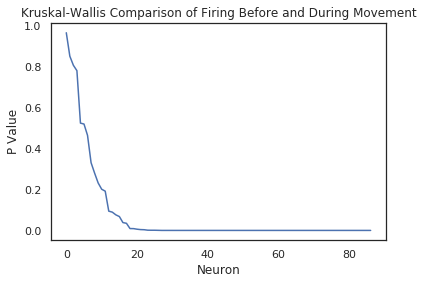

In [71]:
# Using Kruskal-Wallis
nontrial_data = np.array(baseline_neural_datalist)
trial_data = np.array(neural_datalist)
p_vals = []
#sum along trials dim
for i in range(87):
    p_vals.append(kruskal(np.mean(nontrial_data[i], axis=0), np.mean(trial_data[i], axis=0)).pvalue)

threshold = 0.001
task_dependent_units = np.where(np.array(p_vals) < threshold)[0]

plt.plot(np.sort(p_vals)[::-1])
plt.xlabel('Neuron')
plt.ylabel('P Value')
plt.title('Kruskal-Wallis Comparison of Firing Before and During Movement')
print(task_dependent_units.shape)

In [73]:
if instructed_delay:
    #Save DataFrames to temporary folder
    kinematic_df.to_pickle(fpath + 'kinematic_df_delay.pkl')
    neural_df.to_pickle(fpath + 'neural_df_delay.pkl')
    video_df.to_pickle(fpath + 'video_df_delay.pkl')

    #Save metadata
    output = open(fpath + 'metadata_delay.pkl', 'wb')
    pickle.dump(metadata, output)
    output.close()
else
    #Save DataFrames to temporary folder
    kinematic_df.to_pickle(fpath + 'kinematic_df.pkl')
    neural_df.to_pickle(fpath + 'neural_df.pkl')
    video_df.to_pickle(fpath + 'video_df.pkl')

    #Save metadata
    output = open(fpath + 'metadata.pkl', 'wb')
    pickle.dump(metadata, output)
    output.close()

## Visualize Data

In [74]:
kinematic_df.iloc[0,1].shape

(300,)

Plot one axis over time not both at the same time

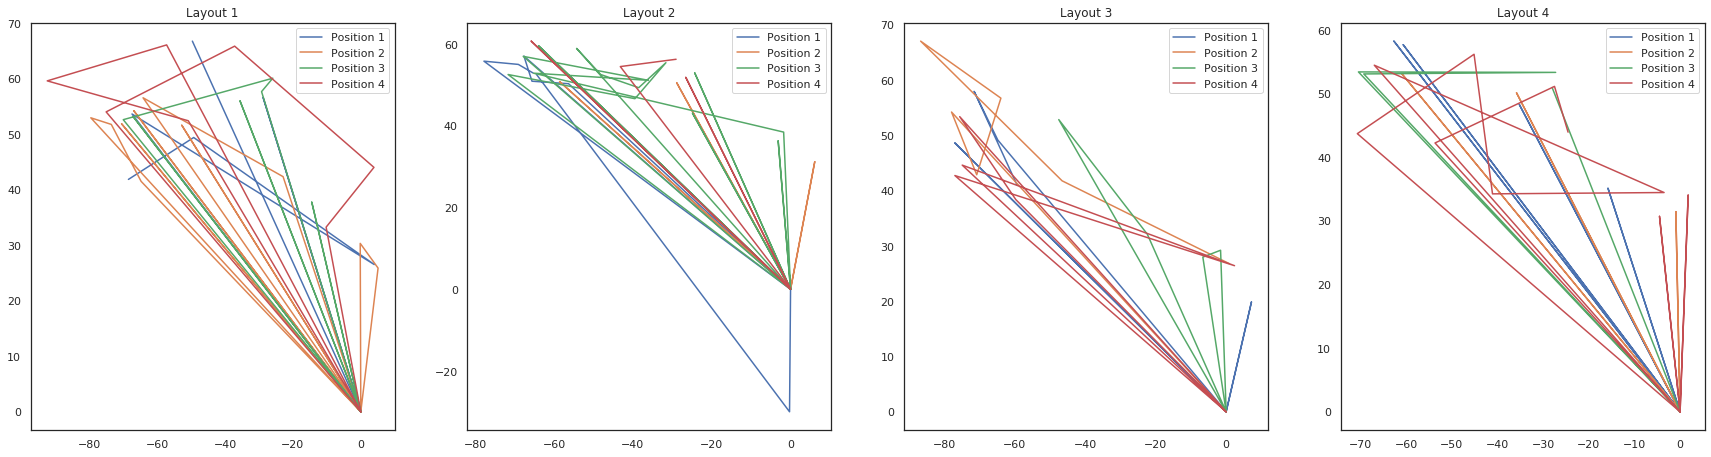

In [75]:
ring_data_x = kinematic_df[kinematic_df['name'] == 'ringProx_x'][['posData', 'position', 'layout']].squeeze() 
ring_data_y =  kinematic_df[kinematic_df['name'] == 'ringProx_y'][['posData', 'position', 'layout']].squeeze()
plot_types = [(idx1, idx2) for idx1 in range(1,5) for idx2 in range(1,5)]
fig, ax = plt.subplots(1,4, figsize=(30,7.5))
plot_data = [ring_data_x, ring_data_y]
for plot_type in plot_types:
    mask = pd.array(np.logical_and(ring_data_y['layout']==plot_type[0], ring_data_y['position']==plot_type[1]))
    ring_data_x_filtered = ring_data_x[mask]['posData'].str[0]
    ring_data_y_filtered = ring_data_y[mask]['posData'].str[0]
    
    ax[plot_type[0]-1].plot(ring_data_x_filtered, ring_data_y_filtered, label = 'Position ' + str(plot_type[1]))
    ax[plot_type[0]-1].set_title('Layout ' + str(plot_type[0]))
    ax[plot_type[0]-1].ylabel = 'Y position'
    ax[plot_type[0]-1].xlabel = 'X position'
    ax[plot_type[0]-1].legend()
    
fig.savefig('../figures/kinematic_trajectories.svg')
    

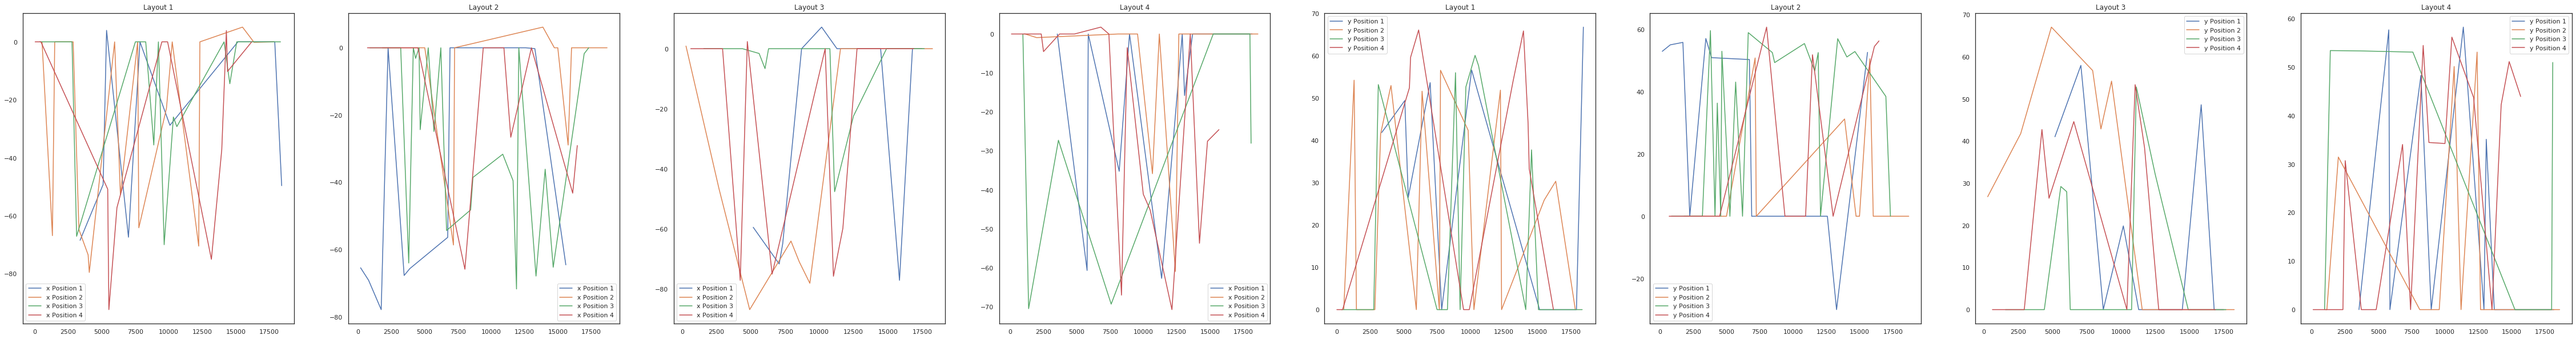

In [76]:
ring_data_x = kinematic_df[kinematic_df['name'] == 'ringProx_x'][['posData', 'position', 'layout']].squeeze() 
ring_data_y =  kinematic_df[kinematic_df['name'] == 'ringProx_y'][['posData', 'position', 'layout']].squeeze()
plot_types = [(idx1, idx2) for idx1 in range(1,5) for idx2 in range(1,5)]
fig, ax = plt.subplots(1,8, figsize=(80,10))
plot_data = [ring_data_x, ring_data_y]
for plot_type in plot_types:
    mask = pd.array(np.logical_and(ring_data_y['layout']==plot_type[0], ring_data_y['position']==plot_type[1]))
    ring_data_x_filtered = ring_data_x[mask]['posData'].str[0]
    ring_data_y_filtered = ring_data_y[mask]['posData'].str[0]
    
    ax[plot_type[0]-1].plot(ring_data_x_filtered, label = 'x Position ' + str(plot_type[1]))
    ax[plot_type[0]-1].set_title('Layout ' + str(plot_type[0]))
    ax[plot_type[0]-1].legend()
    
    ax[plot_type[0]+3].plot(ring_data_y_filtered, label = 'y Position ' + str(plot_type[1]))
    ax[plot_type[0]+3].set_title('Layout ' + str(plot_type[0]))
    ax[plot_type[0]+3].legend()

In [77]:
ring_data_x = kinematic_df[kinematic_df['name'] == 'ringProx_x'][['posData', 'position', 'layout']].squeeze() 
ring_data_y =  kinematic_df[kinematic_df['name'] == 'ringProx_y'][['posData', 'position', 'layout']].squeeze()
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

## Analyze Data

In [25]:
import sys
sys.path.append('/gpfs/home/loconno3/utra2023/code')
import mocap_functions_copy

In [26]:
kinematic_df, neural_df, video_df, metadata = mocap_functions_copy.load_mocap_df('../data/SPK20220308/task_data/')

sampling_rate = 100
kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
neural_offset = 20
offset = neural_offset + kernel_offset
window_size = 20
data_step_size = 1 

num_trials = metadata['num_trials']



#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

# Analysis

In [34]:
import sys
sys.path.append('/gpfs/home/loconno3/utra2023/code')
import mocap_functions_copy
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [35]:
def plot_predictions(y_pred, y_test):
    '''
    Plots the binned firing rates of the predicted neurons and the actual neurons
    Parameters:
    - y_pred (): The predicted binned firing rates
    - y_test (): The actual binned firing rates
    
    Returns: None
    '''
    for n in range(y_test.shape[1]):
        plt.figure(figsize=(8,4))
        plt.title(f'Neuron {n}')
        plt.plot(y_pred[0:4000,n])
        plt.plot(y_test[0:4000,n])

In [36]:
def plot_corr(y_pred, y_test, plt_type=''):   
    '''
    Plots the correlation coefficients of predicted and actual 
    neural data
    Parameters:
    - y_pred (torch.Tensor): The predicted binned firing rates
    - y_test (torch.Tensor): The actual binned firing rates
    
    Returns: regression_test_corr , the correlation coefficients for each neuron
    '''
    regression_test_corr = mocap_functions_copy.matrix_corr(y_pred, y_test, axis=0)
    plt.title(f'Distribution of Correlation Coefficients: {plt_type}')
    plt.ylabel('Number of Neurons')
    plt.xlabel('Correlation Coefficient')
    plt.hist(regression_test_corr)
    return regression_test_corr

In [37]:
def save_as_pickle(fname, data):
    '''
    Helper function to pickle data
    Parameters:
    - fname (string): The file to write the data to
    - data (any): The data to be written
    
    Returns: None
    '''
    with open(fname, "wb") as outfile: 
        pickle.dump(data, outfile)

###Notes 
7/11

PCA on firing rates: Weight for how much variance contributing?
Intertrial interval vs task - if FR different label as task related
Point plots MLP vs linear regression
 SSIMNETS- Color lines
GENERATE POINT PLOTS
Position or velocity, xyz
    Correlation
Look at activity during task vs rest
Try concatenating kinematic and video

In [ ]:
# neuron_corrs['video_mlp'] = regression_test_corr

## CNN

In [95]:
window_size=20
batch_size = 256
input_type = 'video'

# Parameters
train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

In [97]:
if input_type == 'video_kinematic':
    kinematic_type = 'posData'

    predict_kinematics=False
    # Generators
    training_set = Video_Kinematic_Dataset(cv_dict,  fold, 'train_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                     window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=True)
    training_generator = torch.utils.data.DataLoader(training_set, **train_params)
    training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
    X_train_data = training_set[:][0].detach().cpu().numpy()
    y_train_data = training_set[:][1].detach().cpu().numpy()

    validation_set = Video_Kinematic_Dataset(cv_dict,  fold, 'validation_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                     window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=True)
    validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

    testing_set = Video_Kinematic_Dataset(cv_dict,  fold, 'test_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                     window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=True)
    testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
    X_test_data = testing_set[:][0].detach().cpu().numpy()
    y_test_data = testing_set[:][1].detach().cpu().numpy()
    
elif input_type == 'video':
    training_set = Video_Dataset(cv_dict,  fold, 'train_idx', video_path, video_df, neural_df, subsample_scalar=1, load_from_pickle=True)
    validation_set = Video_Dataset(cv_dict,  fold, 'validation_idx', video_path, video_df, neural_df, subsample_scalar=1, load_from_pickle=True)
    testing_set = Video_Dataset(cv_dict,  fold, 'test_idx', video_path, video_df, neural_df, subsample_scalar=1, load_from_pickle=True)

elif input_type == 'kinematic':
    # Set up PyTorch Dataloaders
    fold=0
    kinematic_type = 'posData'

    predict_kinematics=False
    # Generators
    training_set = mocap_functions_copy.SEE_Dataset(cv_dict, fold, 'train_idx', kinematic_df, neural_df, offset, window_size, 
                                                data_step_size, device, 'posData', True, predict_kinematics)
    training_generator = torch.utils.data.DataLoader(training_set, **train_params)
    training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)

    validation_set = mocap_functions_copy.SEE_Dataset(cv_dict, fold, 'validation_idx', kinematic_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', True, predict_kinematics)
    validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

    testing_set = mocap_functions_copy.SEE_Dataset(cv_dict, fold, 'test_idx', kinematic_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', True, predict_kinematics)
    testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
    

82 210 85 135 59 87 40 100 115 110 130 211 187 206 133 205 203 213 48 140 160 199 83 7 158 137 4 117 112 188 111 65 159 119 77 45 96 26 129 215 71 53 118 174 43 91 1 122 46 184 102 208 156 164 202 185 131 168 28 101 16 18 143 114 195 78 64 10 142 194 121 30 95 42 128 60 113 149 108 165 63 139 2 124 17 127 148 154 89 116 162 161 57 167 134 29 86 144 163 170 21 11 19 176 181 216 81 123 106 55 51 126 24 178 197 138 73 75 8 25 109 15 Frame list length: 122
150 169 97 153 38 3 41 52 186 9 157 155 37 98 183 147 67 74 5 94 198 99 68 35 179 92 93 132 84 145 6 90 88 120 189 22 125 23 152 172 Frame list length: 40
27 171 31 193 44 69 214 80 76 20 79 61 105 192 103 62 204 175 146 201 191 56 196 107 177 36 58 104 0 173 212 141 32 207 13 190 136 33 200 180 209 49 34 166 50 39 151 66 12 70 47 14 54 72 182 Frame list length: 55


In [148]:
x_train, y_train = training_set[:]
x_train.detach().cpu().numpy(), y_train.detach().cpu().numpy()
if input_type == 'video':
    x_train = x_train[:,-1,:]
x_train, y_train = x_train.reshape([-1,window_size,x_train.shape[1]]), y_train.reshape([-1,window_size,y_train.shape[1]])
x_train, y_train = np.swapaxes(x_train, 1, 2), np.swapaxes(y_train, 1, 2)
y_train = y_train.type('torch.FloatTensor')
x_train = x_train.type('torch.FloatTensor')
print(x_train.shape)
print(y_train.shape)
print(type(training_set))

torch.Size([605, 2240, 20])
torch.Size([605, 87, 20])
<class '__main__.Video_Dataset'>


In [149]:
x_test, y_test = testing_set[:]
x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy()
if input_type == 'video':
    x_test = x_test[:,-1,:]
y_old = y_test
x_test, y_test = x_test.reshape([-1,window_size,x_test.shape[1]]), y_test.reshape([-1,window_size,y_test.shape[1]])
x_test, y_test = np.swapaxes(x_test, 1, 2), np.swapaxes(y_test, 1, 2)
x_test = x_test.type('torch.FloatTensor')
y_test = y_test.type('torch.FloatTensor')
print(x_test.shape)
print(y_test.shape)
print(type(testing_set))

torch.Size([275, 2240, 20])
torch.Size([275, 87, 20])
<class '__main__.Video_Dataset'>


In [150]:
model = nn.Sequential(
    nn.Conv1d(in_channels=x_train.shape[1], out_channels=window_size, kernel_size=4, padding=2),
    nn.ReLU(),
    nn.Linear(1+window_size, 100),
    nn.ReLU(),
    nn.Linear(100, 87)
)

In [151]:
#Define hyperparameters
lr = 0.0001
weight_decay = 1e-5
max_epochs=1000
# input_size = training_set.x_size
output_size = y_train.shape[1]
batch_size = 256

 
# Define Loss, Optimizerints h
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [152]:
import copy

Training epoch: 0
Training epoch: 100
Training epoch: 200
Training epoch: 300
Training epoch: 400
Training epoch: 500
Training epoch: 600
Training epoch: 700
Training epoch: 800
Training epoch: 900
MSE: 0.84
RMSE: 0.91


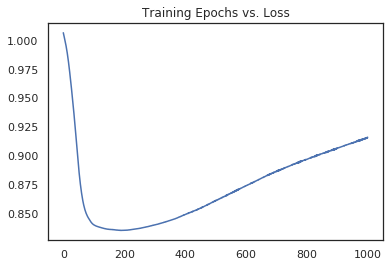

In [153]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(max_epochs):
    model.train()
    for b in range(0, len(x_train), batch_size):
        # take a batch
        X_batch = x_train[b:b+batch_size,:,:]
        y_batch = y_train[b:b+batch_size,:,]
        # forward pass
        y_pred = model(X_batch)
        y_pred = np.swapaxes(y_pred,1,2).type('torch.FloatTensor')
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(x_test)
    y_pred = np.swapaxes(y_pred,1,2).type('torch.FloatTensor')
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    
    if epoch%100==0:
        print(f'Training epoch: {epoch}')
            
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.title('Training Epochs vs. Loss')
plt.plot(history)
plt.show()

0.39222458


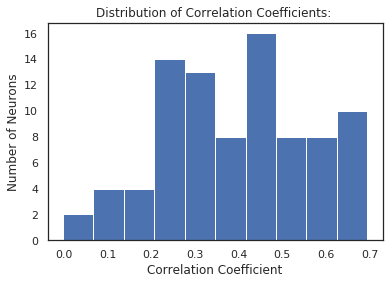

In [154]:
y_test_np = y_test.swapaxes(2,1).reshape([-1,87]).detach().numpy()
y_pred_np = model(x_test).reshape([-1,87]).detach().numpy()
corrs = plot_corr(y_test_np, y_pred_np)
print(np.mean(corrs))

In [155]:
neuron_corrs['Video CNN'] = corrs

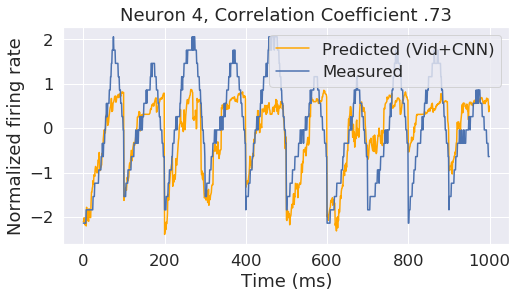

In [342]:
n = np.argmax(corrs)
fig = plt.figure(figsize=(8,4))
plt.title(f'Neuron {n}, Correlation Coefficient .73')
plt.plot(y_pred_np[0:1000,n], color='orange', label='Predicted (Vid+CNN)')
plt.plot(y_test_np[0:1000,n], color='b', label='Measured')
plt.ylabel('Normalized firing rate')
plt.xlabel('Time (ms)')
plt.legend()
fig.savefig('../figures/good_neuron.svg')

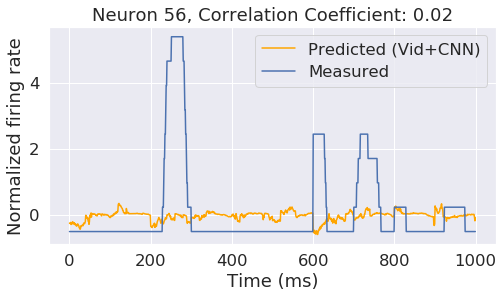

In [343]:
n = np.argmin(corrs)
fig = plt.figure(figsize=(8,4))
plt.title(f'Neuron {n}, Correlation Coefficient: 0.02')
plt.plot(y_pred_np[0:1000,n], color='orange', label='Predicted (Vid+CNN)')
plt.plot(y_test_np[0:1000,n], color='b', label='Measured')
plt.ylabel('Normalized firing rate')
plt.xlabel('Time (ms)')
plt.legend()
fig.savefig('../figures/bad_neuron.svg')

# Seq2seq

In [37]:
import copy

In [108]:
def init_seq2seq_data(input_type = 'kinematic', is_baseline = False, fold = 1, load_from_pickle=True):
    window_size=20
    batch_size = 256
    h1=500
    h2=200
    
    # Parameters
    train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
    validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
    
    
    if input_type == 'video_kinematic':
        kinematic_type = 'posData'

        predict_kinematics=False
        # Generators
        training_set = Video_Kinematic_Dataset(cv_dict,  fold, 'train_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                         window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=load_from_pickle)
        training_generator = torch.utils.data.DataLoader(training_set, **train_params)
        training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
        X_train_data = training_set[:][0].detach().cpu().numpy()
        y_train_data = training_set[:][1].detach().cpu().numpy()

        validation_set = Video_Kinematic_Dataset(cv_dict,  fold, 'validation_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                         window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=load_from_pickle)
        validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

        testing_set = Video_Kinematic_Dataset(cv_dict,  fold, 'test_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                         window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=load_from_pickle)
        testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
        X_test_data = testing_set[:][0].detach().cpu().numpy()
        y_test_data = testing_set[:][1].detach().cpu().numpy()

    elif input_type == 'video':
        training_set = Video_Dataset(cv_dict,  fold, 'train_idx', video_path, video_df, neural_df, subsample_scalar=subsample_scalar, load_from_pickle=load_from_pickle)
        validation_set = Video_Dataset(cv_dict,  fold, 'validation_idx', video_path, video_df, neural_df, subsample_scalar=subsample_scalar, load_from_pickle=load_from_pickle)
        testing_set = Video_Dataset(cv_dict,  fold, 'test_idx', video_path, video_df, neural_df, subsample_scalar=subsample_scalar, load_from_pickle=load_from_pickle)

    elif input_type == 'kinematic':
        # Set up PyTorch Dataloaders

        kinematic_type = 'posData'

        predict_kinematics=False
        # Generators
        training_set = mocap_functions_copy.SEE_Dataset(cv_dict, fold, 'train_idx', kinematic_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', True, predict_kinematics)
        training_generator = torch.utils.data.DataLoader(training_set, **train_params)
        training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)

        validation_set = mocap_functions_copy.SEE_Dataset(cv_dict, fold, 'validation_idx', kinematic_df, neural_df, offset, window_size, 
                                                        data_step_size, device, 'posData', True, predict_kinematics)
        validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

        testing_set = mocap_functions_copy.SEE_Dataset(cv_dict, fold, 'test_idx', kinematic_df, neural_df, offset, window_size, 
                                                        data_step_size, device, 'posData', True, predict_kinematics)
        testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
    
    x_train, y_train = training_set[:]
    x_train.detach().cpu().numpy(), y_train.detach().cpu().numpy()
    if input_type == 'video':
        x_train = x_train[:,-1,:]
    # x_train, y_train = x_train.reshape([-1,window_size,x_train.shape[1]]), y_train.reshape([-1,window_size,y_train.shape[1]])
    # x_train, y_train = np.swapaxes(x_train, 1, 2), np.swapaxes(y_train, 1, 2)
    
    #Shuffle baseline based on number of frames. NOTE WE ARE STILL THROWING AWAY A TRIAL FOR THE VIDEO!!!!!
    if is_baseline:
        x_shape = x_train.shape
        num_trials = len(cv_dict[fold]['train_idx'])
        
        if input_type != 'kinematic':
            num_trials = num_trials - 1
            
        x_train = x_train.reshape(num_trials,-1)
        np.random.shuffle(x_train)
        x_train = x_train.reshape(x_shape)
        
    y_train = y_train.type('torch.FloatTensor')
    x_train = x_train.type('torch.FloatTensor')

    print(x_train.shape)
    print(y_train.shape)
    print(type(training_set))
    
    x_test, y_test = testing_set[:]
    x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy()
    if input_type == 'video':
        x_test = x_test[:,-1,:]
    y_old = y_test
    # x_test, y_test = x_test.reshape([-1,window_size,x_test.shape[1]]), y_test.reshape([-1,window_size,y_test.shape[1]])
    # x_test, y_test = np.swapaxes(x_test, 1, 2), np.swapaxes(y_test, 1, 2)
    x_test = x_test.type('torch.FloatTensor')
    y_test = y_test.type('torch.FloatTensor')
    print(x_test.shape)
    print(y_test.shape)
    print(type(testing_set))
    
    return y_train, x_train, y_test, x_test

In [109]:
# LSTM() returns tuple of (tensor, (recurrent state))
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        #TODO: SHOULD WE SOMEHOW SAVE THE CELL AND HIDDEN STATES
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor

In [110]:
def run_model(model, y_train, x_train, y_test, x_test):
    
    #Define hyperparameters
    lr = 0.0001
    weight_decay = 1e-5
    max_epochs=400
    # input_size = training_set.x_size
    output_size = y_train.shape[1]
    batch_size = 256
    

    # Define Loss, Optimizerints h
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in range(max_epochs):
        model.train()
        for b in range(0, len(x_train), batch_size):
            # take a batch
            X_batch = x_train[b:b+batch_size,:]
            y_batch = y_train[b:b+batch_size,:]
            # forward pass
            y_pred = model(X_batch).type('torch.FloatTensor')
    #         y_pred = np.swapaxes(y_pred,1,2).type('torch.FloatTensor')
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(x_test).type('torch.FloatTensor')
    #     y_pred = np.swapaxes(y_pred,1,2).type('torch.FloatTensor')
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)

        if epoch%100==0:
            print(f'Training epoch: {epoch}')

        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.title('Training Epochs vs. Loss')
    plt.plot(history)
    plt.show()
    
    return model

In [62]:
def run_seq2seq(input_type = 'kinematic', is_baseline = False, fold = 0):
    window_size=20
    h1=500
    h2=200
    y_train, x_train, y_test, x_test = init_seq2seq_data(input_type = input_type, is_baseline = is_baseline, fold = fold)
    model = nn.Sequential(
                nn.Linear(x_train.shape[1], h1),
                nn.ReLU(),
                nn.LSTM(h1, h2, bidirectional=True),
                extract_tensor(),
                nn.ReLU(),
                nn.Linear(2*h2, 87)
            )
    model = run_model(model, y_train, x_train, y_test, x_test)
    y_test_np = y_test.detach().numpy()
    y_pred_np = model(x_test).detach().numpy()
    corrs = plot_corr(y_test_np, y_pred_np)
    print(np.mean(corrs))
    return corrs

In [54]:
with open("neuron_corrs.pkl", "rb") as input_file:
    neuron_corrs = pickle.load(input_file)

In [55]:
import copy

In [104]:
# Set parameters
folds = 1
out_file = "neuron_corrs_delay_baseline.pkl"
is_baseline = True

In [ ]:
delay_corrs = {}
input_types = ['kinematic', 'video', 'video_kinematic']
for input_type in input_types:
    for fold in range(folds):
        print(f'Input type: {input_type}, Fold: {fold}')
        corrs = run_seq2seq(input_type=input_type, is_baseline=is_baseline, fold=fold)
        delay_corrs[f'{input_type}_delay'] = corrs
        with open(out_file, "wb") as output_file:
            pickle.dump(delay_corrs, output_file)

Input type: kinematic, Fold: 0


/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/users/loconno3/anaconda/SEE/lib/python3.7/site-pa

torch.Size([36600, 86])
torch.Size([36600, 87])
<class 'mocap_functions_copy.SEE_Dataset'>
torch.Size([16500, 86])
torch.Size([16500, 87])
<class 'mocap_functions_copy.SEE_Dataset'>
Training epoch: 0
Training epoch: 100


In [73]:
with open("neuron_corrs.pkl", "wb") as outfile: 
    pickle.dump(neuron_corrs, outfile)

## Multi-Stream Model

2/21/2024
- Normalize across each kinematic dimension, normalize video separately
- Switch to better data

# Kinematic Analysis

## Regression

In [49]:
reg = LinearRegression().fit(X_train_data, y_train_data)
y_pred = reg.predict(X_test_data)
reg.score(X_test_data, y_test_data)

0.04426157057928184

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

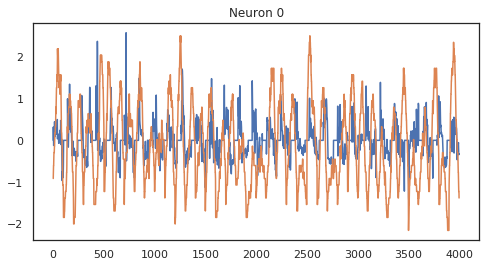

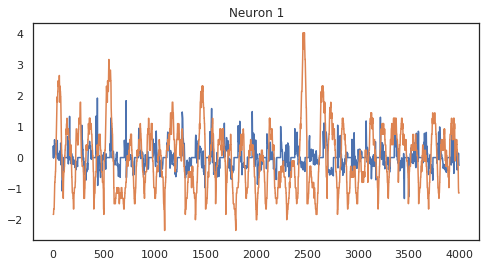

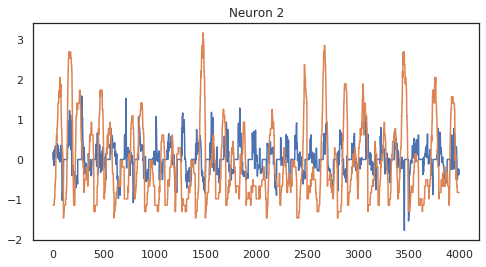

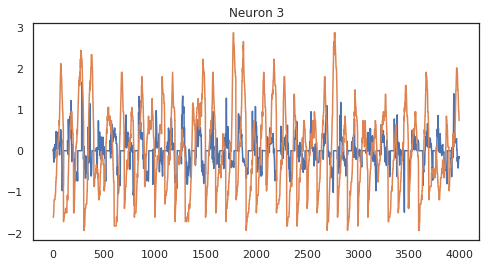

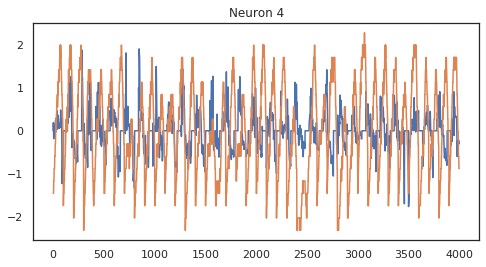

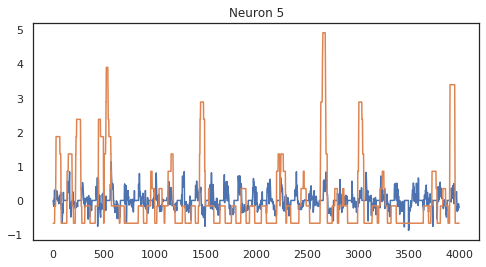

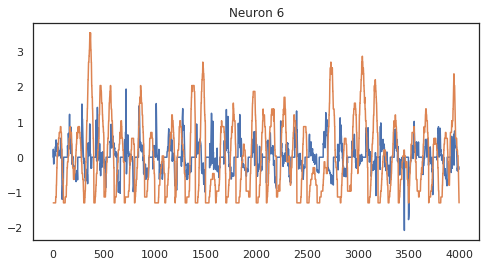

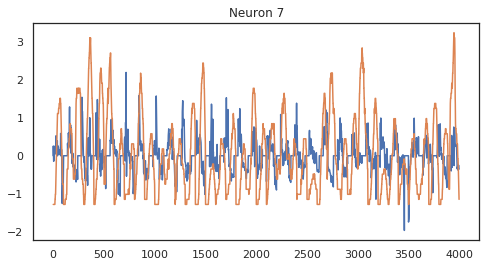

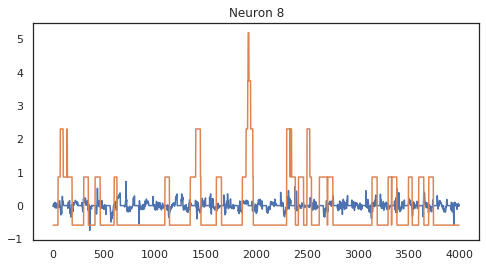

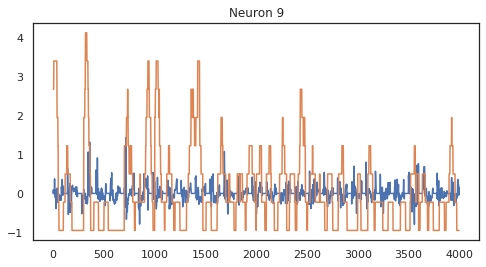

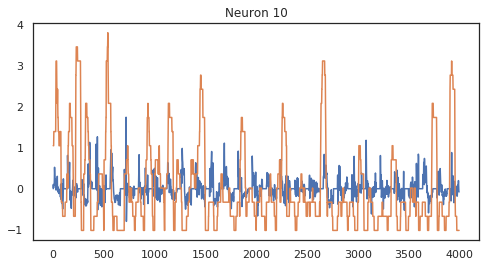

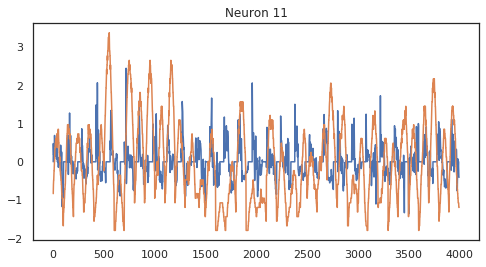

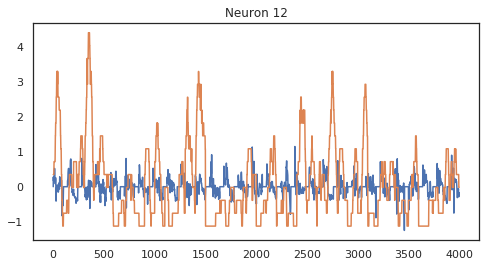

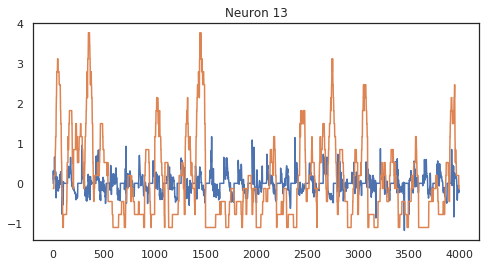

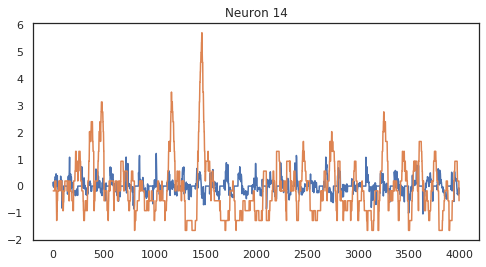

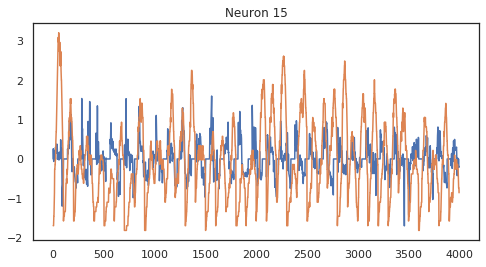

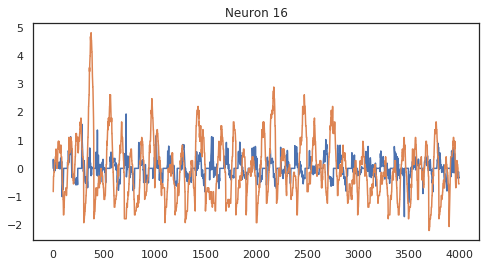

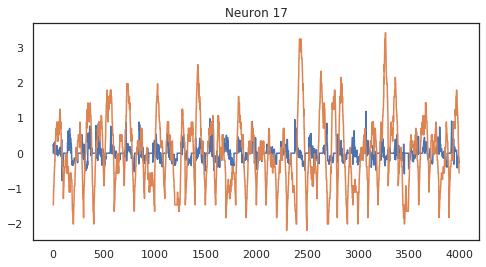

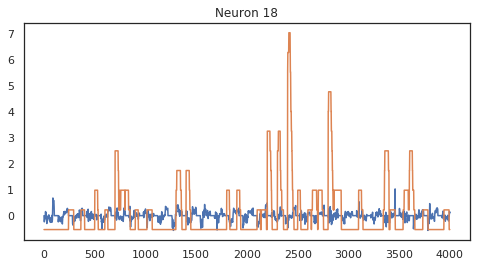

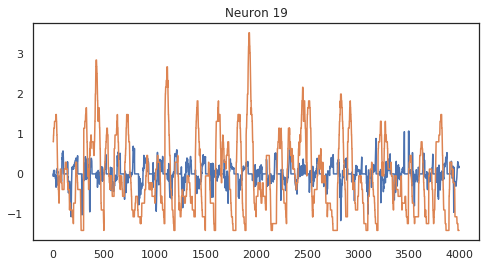

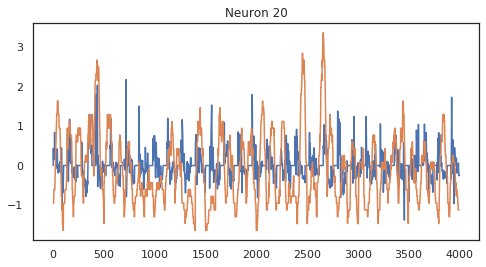

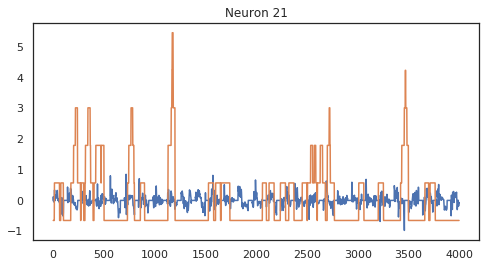

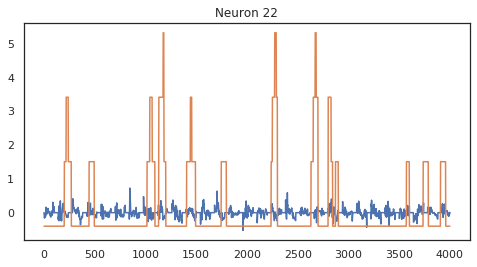

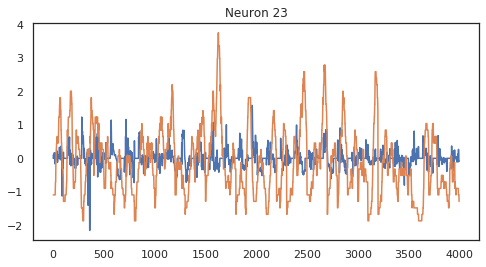

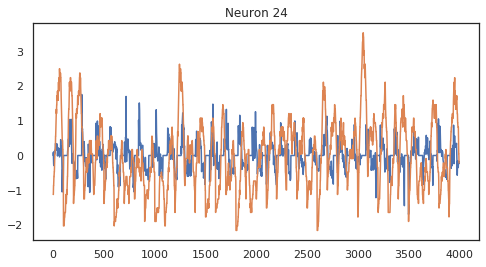

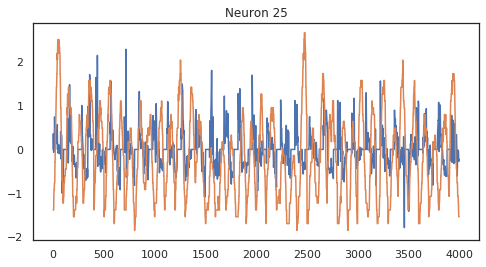

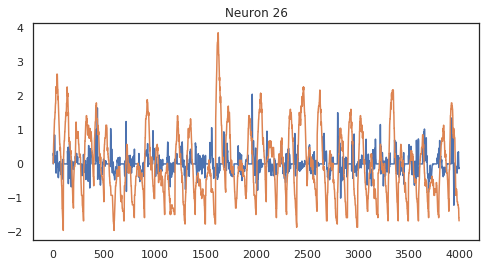

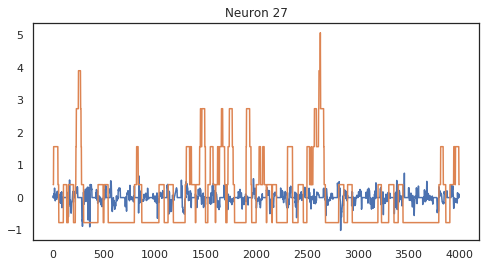

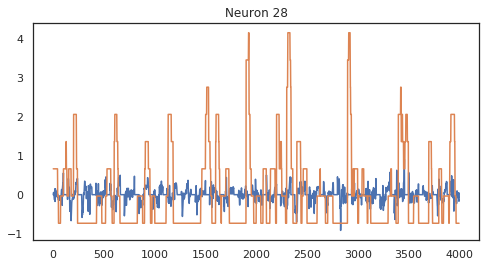

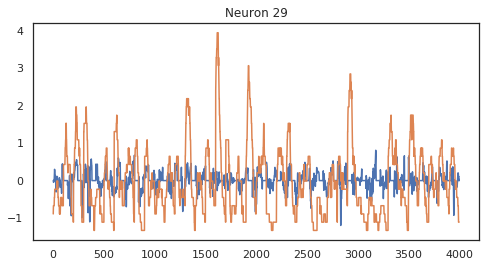

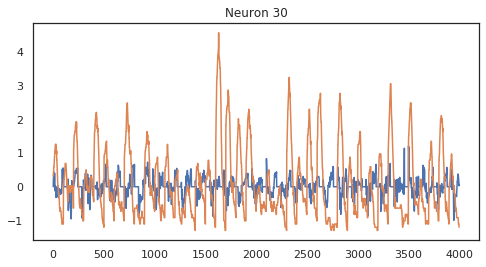

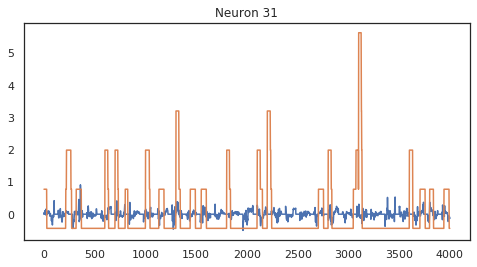

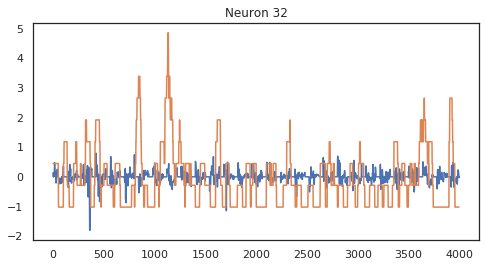

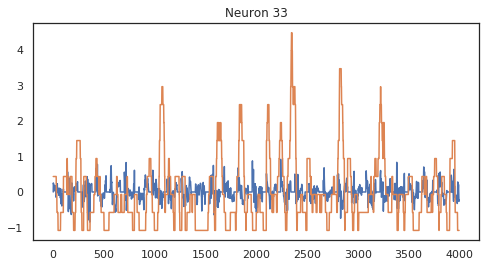

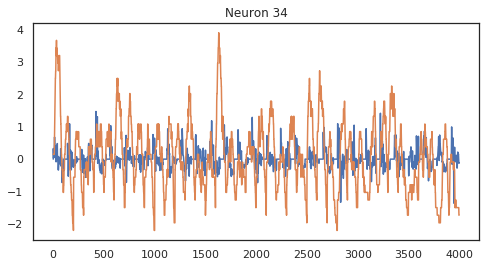

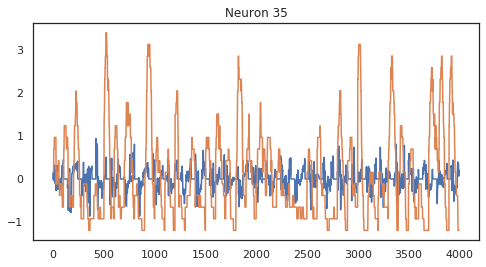

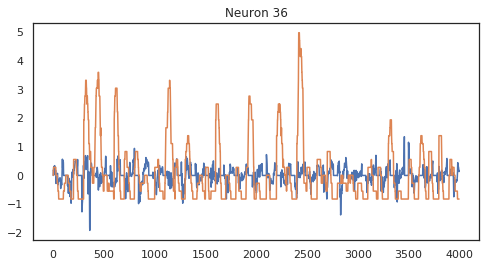

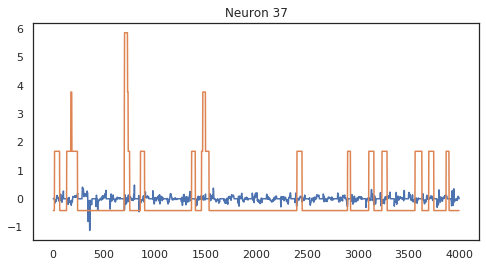

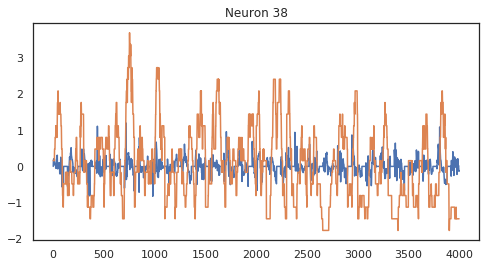

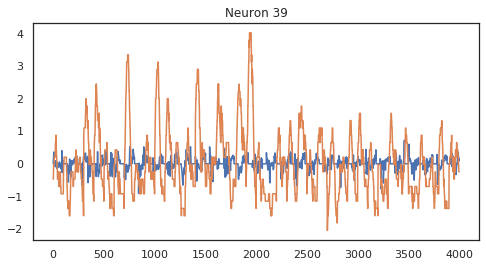

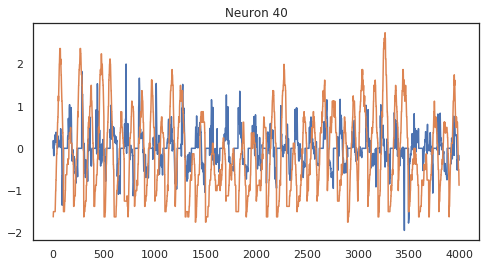

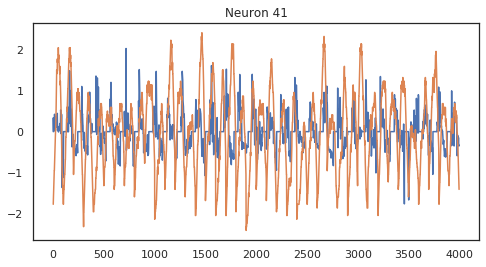

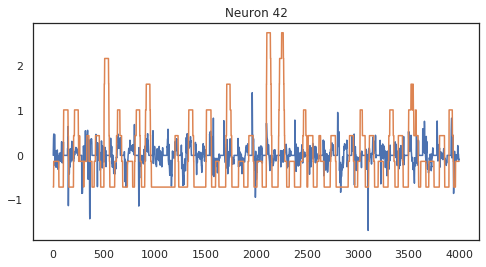

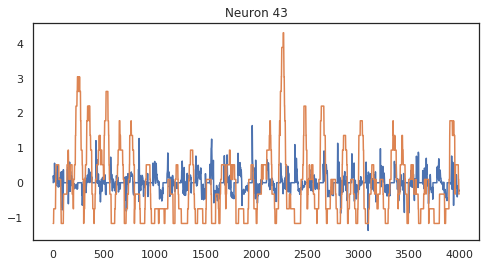

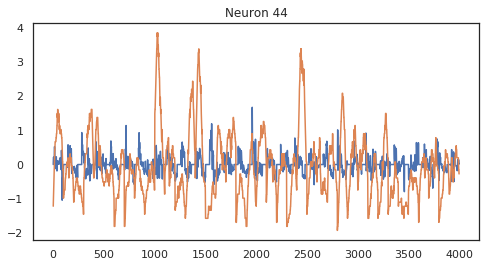

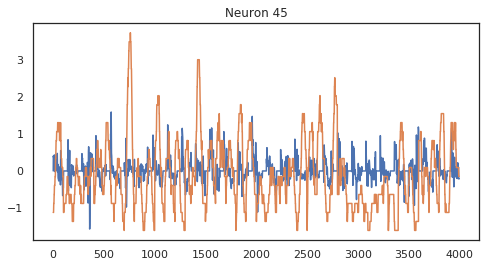

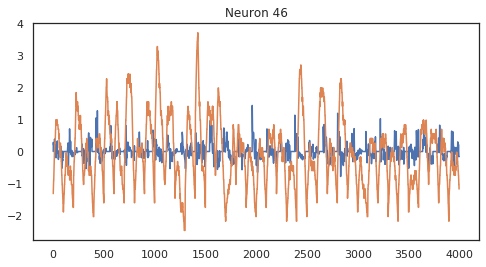

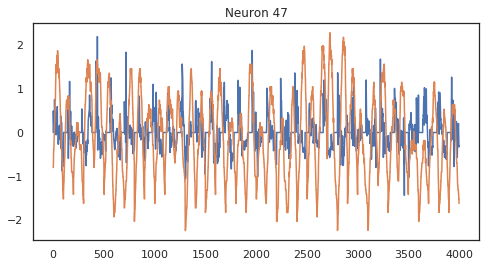

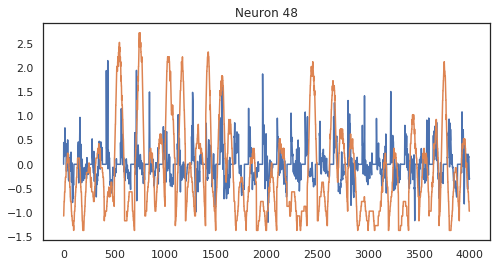

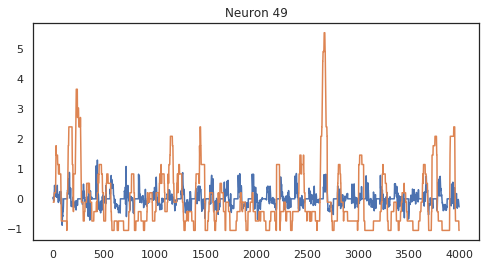

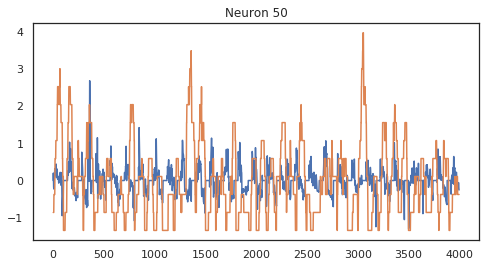

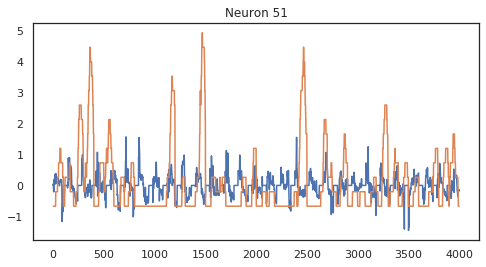

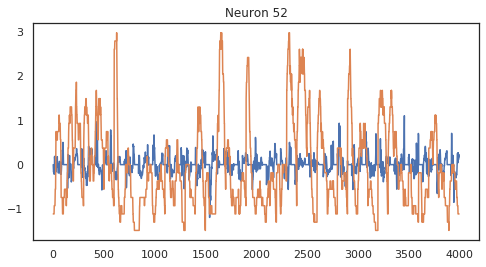

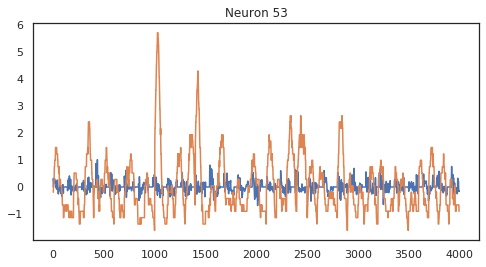

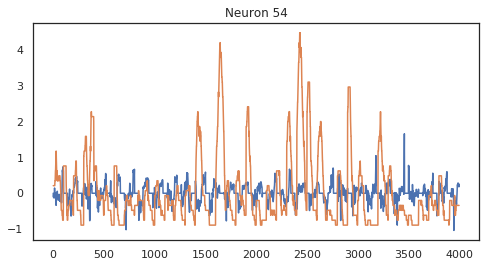

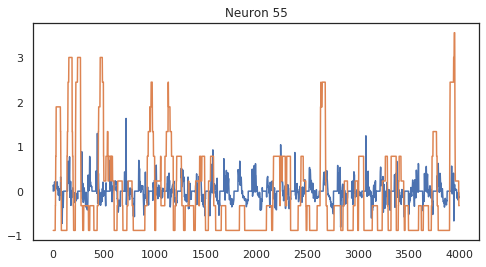

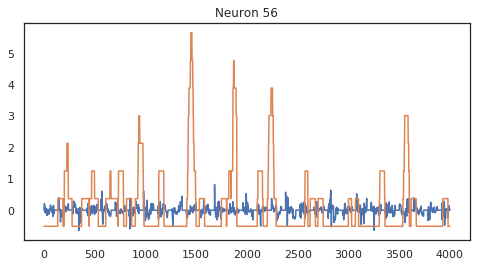

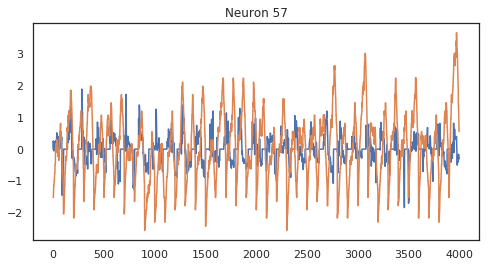

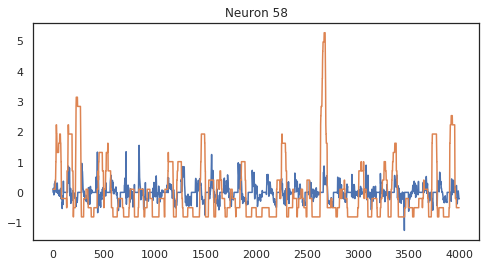

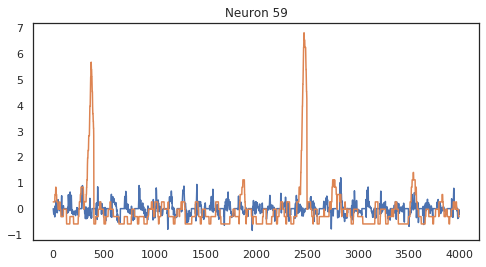

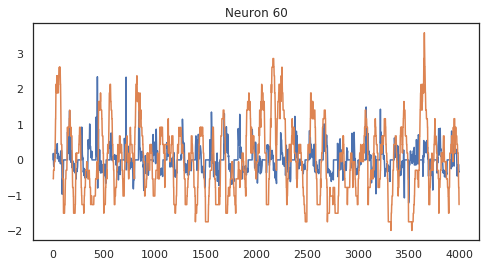

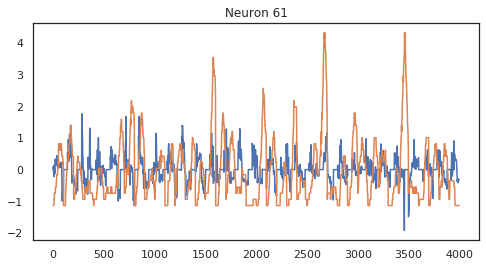

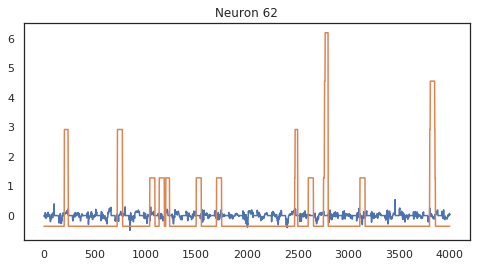

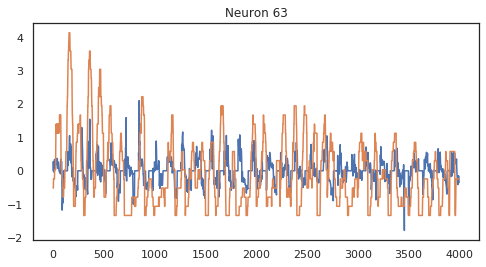

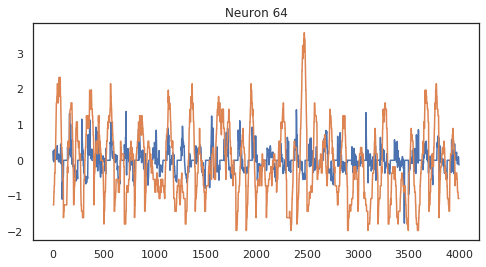

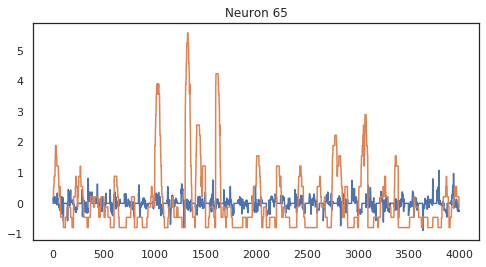

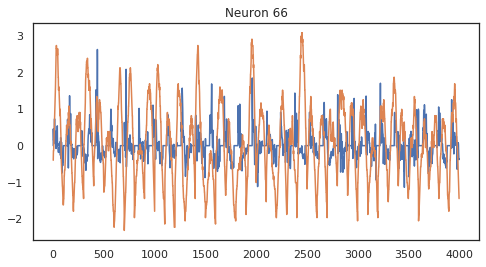

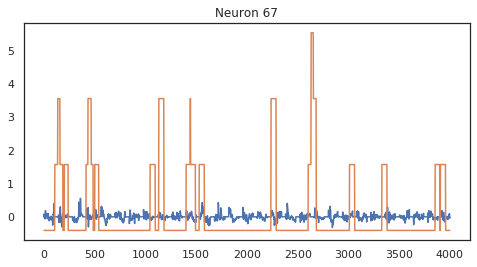

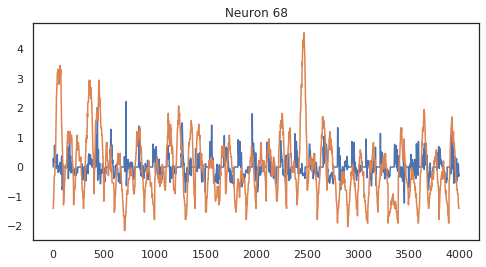

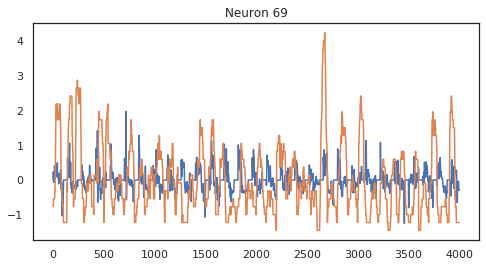

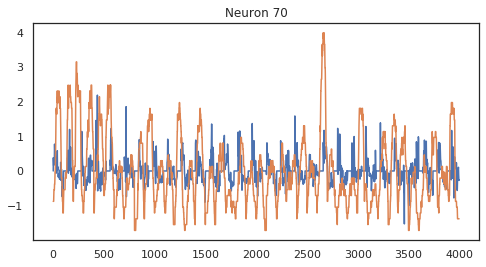

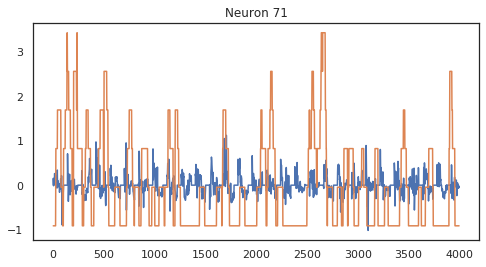

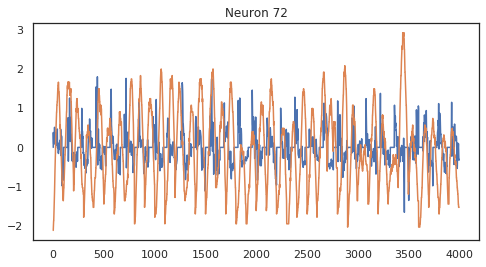

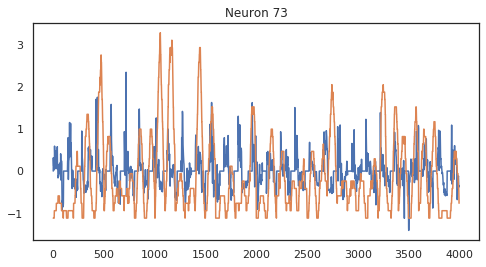

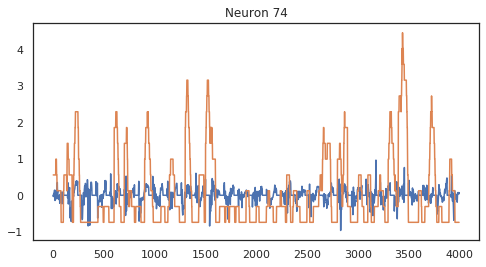

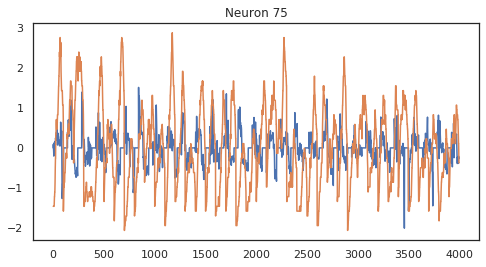

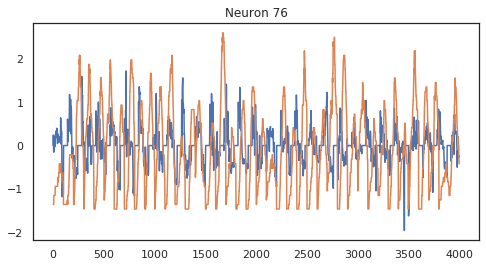

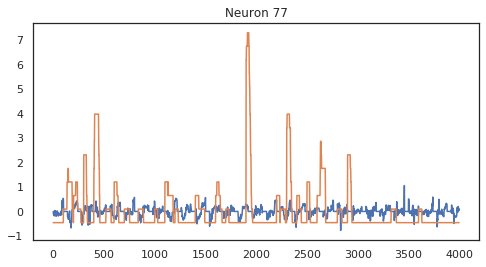

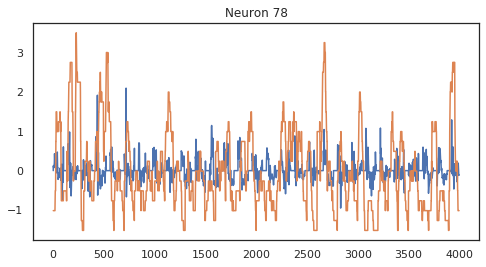

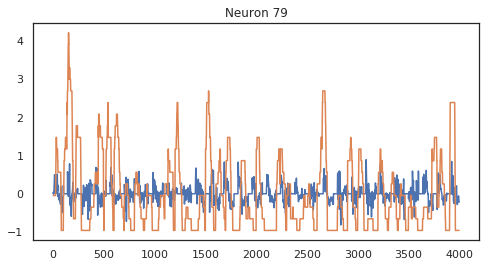

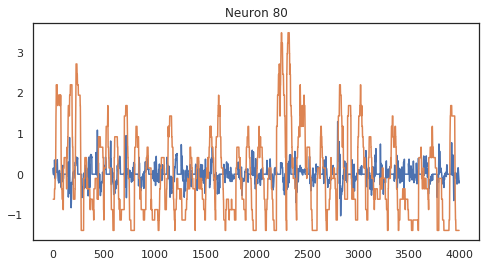

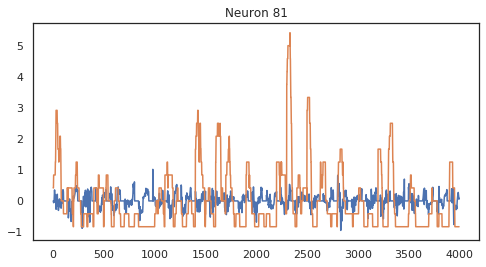

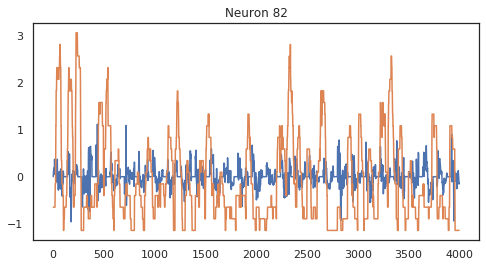

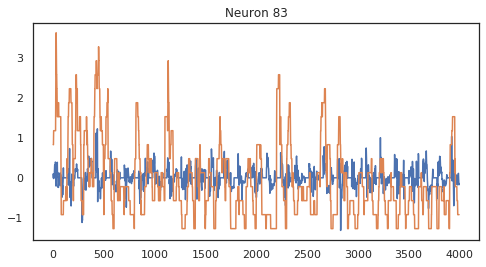

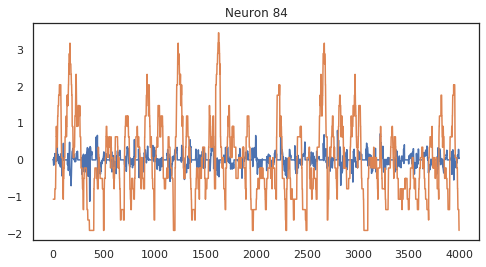

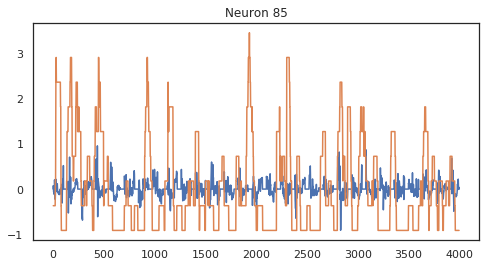

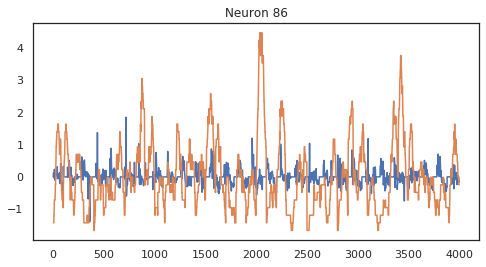

In [90]:
for n in range(y_test.shape[1]):
    plt.figure(figsize=(8,4))
    plt.title(f'Neuron {n}')
    plt.plot(y_pred[0:4000,n])
    plt.plot(y_test[0:4000,n])

(array([ 5., 14., 14.,  8.,  8.,  6.,  6.,  7.,  6., 13.]),
 array([0.00701674, 0.0473858 , 0.08775486, 0.12812392, 0.16849297,
        0.20886203, 0.24923109, 0.28960014, 0.3299692 , 0.37033826,
        0.41070732]),
 <a list of 10 Patch objects>)

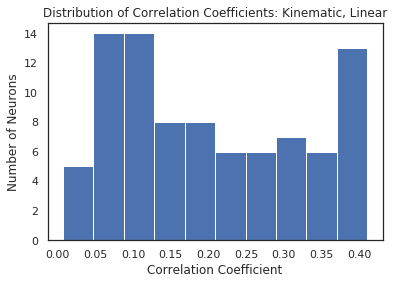

In [50]:
reg_corr = mocap_functions_copy.matrix_corr(y_pred,y_test_data)
plt.title('Distribution of Correlation Coefficients: Kinematic, Linear')
plt.ylabel('Number of Neurons')
plt.xlabel('Correlation Coefficient')
plt.hist(reg_corr)

In [136]:
np.mean(multistream_corrs)

0.468233

In [51]:
neuron_corrs['kinematic_lr'] = reg_corr

## MLP

In [94]:
reg = MLPRegressor(hidden_layer_sizes=(400, 200, 100), learning_rate_init=0.0001, max_iter=1000, activation='tanh', alpha=0.001, batch_size=1000).fit(X_train_data, y_train_data)

y_pred = reg.predict(X_test_data)
reg.score(X_test_data, y_test_data)

-0.2137166848580301

Average Correlation: 0.34552036268492775
Mean Squared Error: 1.2137166848580303


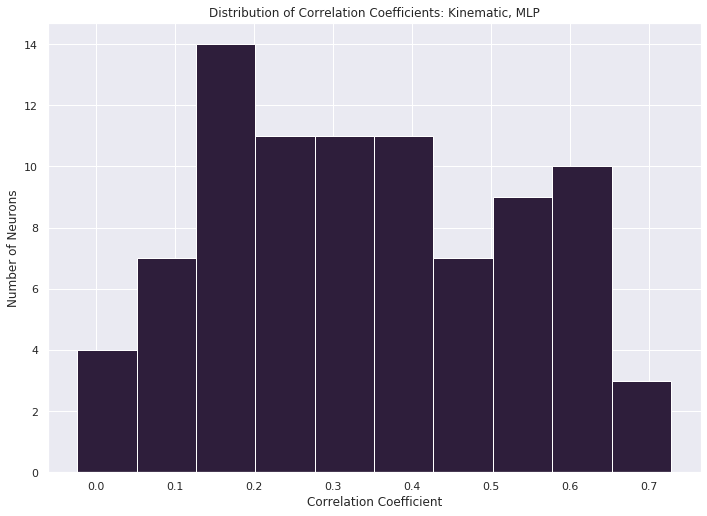

In [95]:
regression_test_corr = mocap_functions_copy.matrix_corr(y_pred, y_test_data, axis=0)
plt.title('Distribution of Correlation Coefficients: Kinematic, MLP')
plt.ylabel('Number of Neurons')
plt.xlabel('Correlation Coefficient')
plt.hist(regression_test_corr)
print(f'Average Correlation: {np.average(regression_test_corr)}')
print(f'Mean Squared Error: {mean_squared_error(y_test_data, y_pred)}')

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/users/loconno3/anaconda/SEE/lib/python3.7/site-pa

-0.07019898664228708
0


/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/users/loconno3/anaconda/SEE/lib/python3.7/site-pa

-0.016182698668375503
1


/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/users/loconno3/anaconda/SEE/lib/python3.7/site-pa

-0.041930481173514556
2


/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/users/loconno3/anaconda/SEE/lib/python3.7/site-pa

0.03335210965383933
3


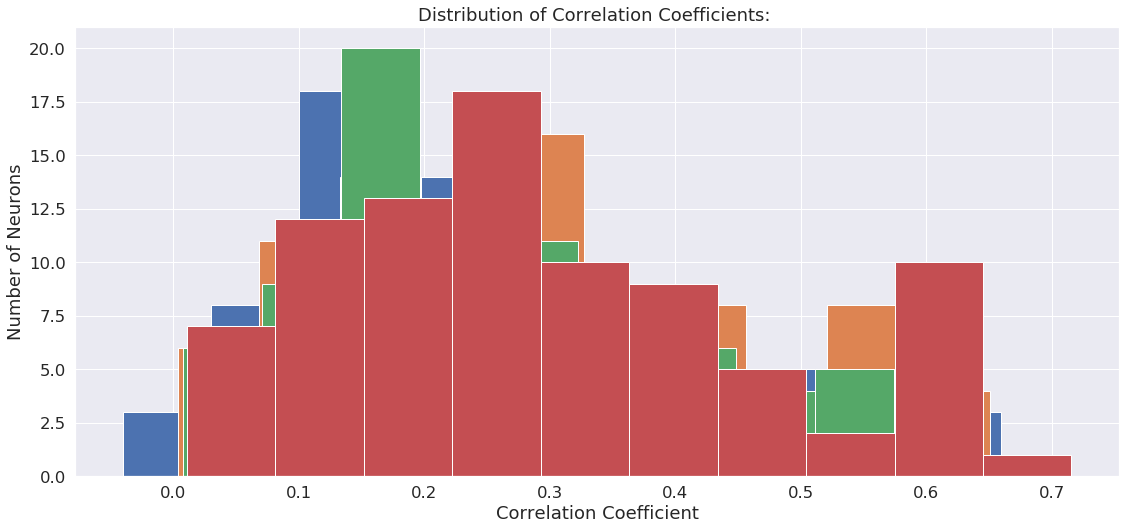

In [297]:
corrs = []
for fold in range(4):
    training_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'train_idx', kinematic_df, neural_df, offset, window_size, 
                                            data_step_size, device, 'posData', True, predict_kinematics)
    training_generator = torch.utils.data.DataLoader(training_set, **train_params)
    training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
    x_train = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train = training_set[:][1][:,-1,:].detach().cpu().numpy()

    validation_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'validation_idx', kinematic_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', True, predict_kinematics)
    validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

    testing_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'test_idx', kinematic_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', True, predict_kinematics)
    testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
    x_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

    x_val = validation_set[:][0][:,-1,:].detach().cpu().numpy()
    y_val = validation_set[:][1][:,-1,:].detach().cpu().numpy()
    
    y_pred, reg = run_mlp(x_train, y_train, x_val, y_val)
    corr = plot_corr(y_pred, y_val)
    corrs.append(corr)
    print(fold)

In [217]:
# neuron_corrs['kinematic_mlp'] = regression_test_corr
neuron_corrs['Position MLP'] = np.mean(corrs, axis=0)

In [298]:
position_corrs = corrs

In [56]:
with open("baseline_corrs.pkl", "rb") as input_file:
    baseline_corrs = pickle.load(input_file)
baseline_corrs

{'kinematic_baseline': array([0.76506174, 0.7830873 , 0.7595896 , 0.81576556, 0.86325324,
        0.44225112, 0.7860809 , 0.77397597, 0.22312544, 0.42728528,
        0.50654745, 0.8410082 , 0.28420293, 0.4076251 , 0.31307688,
        0.81140333, 0.72895086, 0.5021668 , 0.37764612, 0.6468437 ,
        0.6753532 , 0.2961748 , 0.11412904, 0.42275414, 0.7205236 ,
        0.8035616 , 0.80695677, 0.18163337, 0.27902105, 0.60295844,
        0.8246908 , 0.08119635, 0.52280855, 0.36477554, 0.6323753 ,
        0.609795  , 0.702961  , 0.09417962, 0.24086258, 0.5804275 ,
        0.84445876, 0.8106534 , 0.4301151 , 0.4642468 , 0.47263068,
        0.6413205 , 0.7944972 , 0.81200695, 0.7888708 , 0.49100468,
        0.6070595 , 0.48158783, 0.5662482 , 0.5002105 , 0.65698063,
        0.42682123, 0.09614755, 0.83764756, 0.49906904, 0.17394927,
        0.61675924, 0.7603636 , 0.04999797, 0.6746073 , 0.5829977 ,
        0.20141028, 0.8368498 , 0.2340781 , 0.70486265, 0.51617855,
        0.7257112 , 0.2737

In [61]:

del neuron_corrs['Video-Kinematic CNN']
del neuron_corrs['kinematic']

neuron_corrs

{'Video-Kinematic bi-RNN': array([0.5982634 , 0.6003902 , 0.5675735 , 0.7149853 , 0.7518406 ,
        0.21282814, 0.6886239 , 0.6605051 , 0.18392348, 0.46540442,
        0.22658317, 0.7128426 , 0.2959176 , 0.31288174, 0.28089723,
        0.70193815, 0.6112379 , 0.4701088 , 0.3701426 , 0.7391181 ,
        0.51212007, 0.3757101 , 0.05557247, 0.5558236 , 0.625503  ,
        0.7706695 , 0.6564528 , 0.17106359, 0.38999045, 0.5056459 ,
        0.73194236, 0.42428315, 0.46458822, 0.41852483, 0.57096386,
        0.6159479 , 0.71524   , 0.13900428, 0.37789476, 0.5952826 ,
        0.7870866 , 0.7229118 , 0.36134383, 0.44318599, 0.676826  ,
        0.4347207 , 0.60212356, 0.7794179 , 0.56211734, 0.2682426 ,
        0.42051378, 0.4148672 , 0.5488143 , 0.4154057 , 0.5892187 ,
        0.26214814, 0.14165965, 0.7103898 , 0.2622803 , 0.57523715,
        0.29012576, 0.62745595, 0.25141314, 0.53956723, 0.61087567,
        0.14348796, 0.67191243, 0.09577172, 0.6084214 , 0.34517512,
        0.49860007, 0.

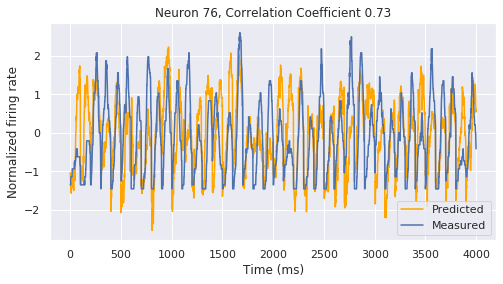

In [157]:
n = np.argmax(regression_test_corr)
fig = plt.figure(figsize=(8,4))
plt.title(f'Neuron {n}, Correlation Coefficient {round(np.max(regression_test_corr), 2)}')
plt.plot(y_pred[0:4000,n], color='orange', label='Predicted')
plt.plot(y_test[0:4000,n], color='b', label='Measured')
plt.ylabel('Normalized firing rate')
plt.xlabel('Time (ms)')
plt.legend()
fig.savefig('../figures/good_neuron.svg')

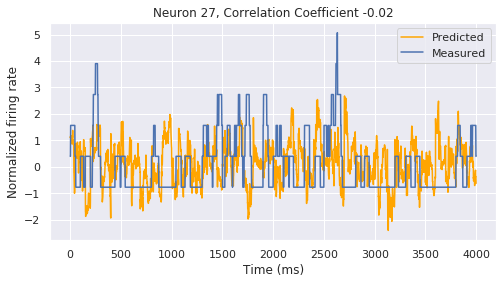

In [156]:
n = np.argmin(regression_test_corr)
fig = plt.figure(figsize=(8,4))
plt.title(f'Neuron {n}, Correlation Coefficient {round(np.min(regression_test_corr),2)}')
plt.plot(y_pred[0:4000,n], color='orange', label='Predicted')
plt.plot(y_test[0:4000,n], color='b', label='Measured')
plt.ylabel('Normalized firing rate')
plt.xlabel('Time (ms)')
plt.legend()
fig.savefig('../figures/bad_neuron.svg')

## Video and Kinematic Data (Concatenated)

In [55]:
kinematic_type = 'posData'
# Parameters
batch_size = 10000
train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

predict_kinematics=False
# Generators
training_set = Video_Kinematic_Dataset(cv_dict,  fold, 'train_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                 window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=True)
training_generator = torch.utils.data.DataLoader(training_set, **train_params)
training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
X_train_data = training_set[:][0].detach().cpu().numpy()
y_train_data = training_set[:][1].detach().cpu().numpy()

validation_set = Video_Kinematic_Dataset(cv_dict,  fold, 'validation_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                 window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=True)
validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

testing_set = Video_Kinematic_Dataset(cv_dict,  fold, 'test_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                 window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=True)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
X_test_data = testing_set[:][0].detach().cpu().numpy()
y_test_data = testing_set[:][1].detach().cpu().numpy()

189 149 107 169 174 82 58 17 150 179 84 130 132 112 119 118 207 153 133 96 3 102 68 126 40 49 195 35 214 193 177 115 43 164 216 50 38 53 95 203 196 92 31 54 127 19 30 23 146 85 52 172 11 26 182 48 6 47 142 77 24 89 181 87 2 13 120 27 159 213 192 113 44 175 70 122 105 202 165 56 28 42 20 143 73 103 29 147 14 160 128 155 210 183 205 104 106 57 185 78 34 67 41 215 51 131 36 9 46 98 25 204 64 121 199 180 75 188 94 114 59 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


117 140 69 8 65 209 167 62 101 186 148 187 99 100 170 151 197 21 1 81 10 72 137 157 39 158 88 166 168 32 208 211 91 176 194 163 97 0 79 60 93 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


201 90 71 144 55 198 111 83 76 5 37 86 161 61 141 173 190 200 12 156 110 135 74 171 129 145 18 178 15 206 152 7 116 63 108 139 136 134 33 125 138 212 109 184 123 16 191 80 66 22 124 45 154 4 162 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


189 149 107 169 174 82 58 17 150 179 84 130 132 112 119 118 207 153 133 96 3 102 68 126 40 49 195 35 214 193 177 115 43 164 216 50 38 53 95 203 196 92 31 54 127 19 30 23 146 85 52 172 11 26 182 48 6 47 142 77 24 89 181 87 2 13 120 27 159 213 192 113 44 175 70 122 105 202 165 56 28 42 20 143 73 103 29 147 14 160 128 155 210 183 205 104 106 57 185 78 34 67 41 215 51 131 36 9 46 98 25 204 64 121 199 180 75 188 94 114 59 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


117 140 69 8 65 209 167 62 101 186 148 187 99 100 170 151 197 21 1 81 10 72 137 157 39 158 88 166 168 32 208 211 91 176 194 163 97 0 79 60 93 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


201 90 71 144 55 198 111 83 76 5 37 86 161 61 141 173 190 200 12 156 110 135 74 171 129 145 18 178 15 206 152 7 116 63 108 139 136 134 33 125 138 212 109 184 123 16 191 80 66 22 124 45 154 4 162 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-0.3164062176568837
0
203 20 45 202 73 173 67 25 118 36 18 110 103 49 69 175 137 94 116 6 32 213 92 14 139 16 27 84 33 35 61 9 64 120 83 56 176 91 75 149 158 0 142 133 74 207 28 81 128 1 165 101 145 130 63 43 125 107 34 178 135 122 66 174 163 193 204 7 72 177 111 8 99 212 148 86 168 23 131 121 136 114 68 77 58 211 85 97 169 79 112 5 3 44 41 109 186 17 198 199 129 2 164 105 11 93 51 151 82 19 46 184 24 201 189 26 196 30 180 80 127 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


156 29 106 123 146 13 162 42 209 214 31 140 167 89 171 205 22 53 194 210 55 108 185 159 39 60 181 166 117 88 144 115 182 4 71 126 52 208 138 141 87 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


96 47 21 98 132 143 10 70 188 197 172 215 102 191 113 192 157 183 155 100 12 37 187 59 40 179 216 65 152 50 95 54 154 195 200 150 15 161 104 90 62 153 78 38 57 124 206 190 119 134 160 76 170 147 48 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-0.28146756419330154
1
72 6 12 26 171 91 94 78 69 123 90 84 27 195 212 159 4 135 200 137 133 87 13 37 119 65 0 210 43 140 18 80 109 154 98 125 187 114 61 60 34 134 33 99 162 64 59 157 93 170 148 107 95 77 151 96 117 174 128 111 176 2 153 112 146 103 102 144 191 193 126 185 152 74 175 155 165 145 188 56 161 108 122 211 51 20 58 129 53 66 209 149 83 189 198 82 130 192 172 97 28 42 62 57 50 32 208 36 45 22 203 89 182 196 41 205 88 67 30 168 47 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


3 104 105 179 71 116 39 75 31 204 76 7 131 115 73 215 15 68 166 9 147 163 202 10 63 19 138 38 46 24 35 183 136 106 79 121 100 167 113 85 55 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


127 48 199 11 180 44 101 23 70 213 150 169 214 190 143 160 186 201 207 158 29 92 120 194 86 156 14 52 216 142 124 141 177 181 1 40 16 164 132 49 25 8 118 17 81 21 110 178 197 139 5 206 173 54 184 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-0.24339239515196304
2
9 79 59 42 124 7 32 102 30 90 18 5 2 156 10 164 87 180 200 120 1 105 39 53 83 191 46 68 49 34 48 73 51 28 167 147 213 154 66 210 184 209 29 183 71 94 22 189 85 163 214 146 207 195 216 143 123 97 36 185 110 19 173 99 12 162 198 199 21 6 43 135 129 80 4 118 171 182 177 107 193 65 108 103 16 75 127 192 37 141 26 20 111 76 116 153 196 40 176 45 134 119 181 155 145 121 54 157 161 62 151 52 169 152 72 93 203 190 89 150 84 175 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


206 215 128 187 100 201 109 160 133 50 204 104 131 0 148 3 47 81 117 174 132 64 13 142 115 126 212 88 33 179 23 186 122 63 112 74 113 15 194 38 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


205 166 25 139 55 86 24 211 114 58 8 69 178 77 172 208 91 144 31 98 92 149 202 168 96 11 158 138 137 35 140 41 82 70 125 27 57 159 67 61 188 170 14 95 56 44 106 17 78 130 101 165 60 136 197 

/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-0.330787258750871
3


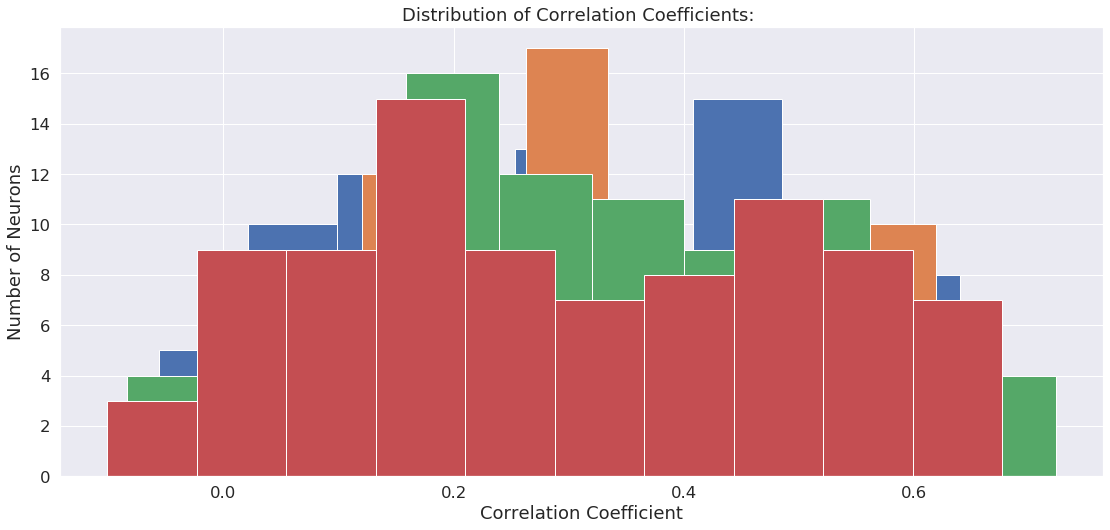

In [301]:
corrs = []
for fold in range(4):
    
    training_set = Video_Kinematic_Dataset(cv_dict,  fold, 'train_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                                           window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=True)
    training_generator = torch.utils.data.DataLoader(training_set, **train_params)
    training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
    x_train = training_set[:][0][:].detach().cpu().numpy()
    y_train = training_set[:][1][:].detach().cpu().numpy()

    validation_set = Video_Kinematic_Dataset(cv_dict,  fold, 'validation_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                     window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=True)
    validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

    testing_set = Video_Kinematic_Dataset(cv_dict,  fold, 'test_idx', video_path, kinematic_df, video_df, neural_df, offset, 
                     window_size, data_step_size, device, predict_kinematics, subsample_scalar=1, load_from_pickle=True)
    testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
    X_test_data = testing_set[:][0].detach().cpu().numpy()
    y_test_data = testing_set[:][1].detach().cpu().numpy() 
    
    x_val = validation_set[:][0][:].detach().cpu().numpy()
    y_val = validation_set[:][1][:].detach().cpu().numpy()
    
    y_pred, reg = run_mlp(x_train, y_train, x_val, y_val)
    corr = plot_corr(y_pred, y_val)
    corrs.append(corr)
    print(fold)

In [245]:
neuron_corrs['Video-Position MLP'] = np.mean(corrs, axis=0)

In [302]:
video_pos_corrs = corrs

In [60]:
print(X_train_data.shape)
print(y_train_data.shape)
y_pred, _ = run_lr(X_train_data, y_train_data, X_test_data, y_test_data)

(12100, 902)
(12100, 87)
-1.476138028877919


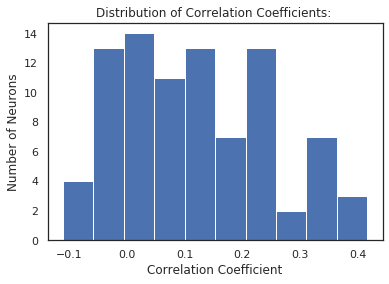

In [61]:
regression_test_corr = plot_corr(y_pred, y_test)
neuron_corrs['vid_kinematic_lr'] = regression_test_corr

-0.22624907359662738


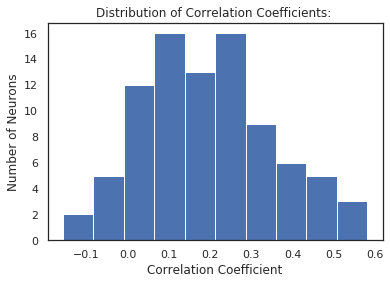

In [58]:
y_pred, _ = run_mlp(X_train_data, y_train_data, X_test_data, y_test_data)
regression_test_corr = plot_corr(y_pred, y_test)
neuron_corrs['vid_kinematic_mlp'] = regression_test_corr

# Summary Figures

In [54]:
with open("neuron_corrs.pkl", "wb") as infile: 
    pickle.dump(infile)

{'Video-Kinematic bi-RNN': array([0.5982634 , 0.6003902 , 0.5675735 , 0.7149853 , 0.7518406 ,
        0.21282814, 0.6886239 , 0.6605051 , 0.18392348, 0.46540442,
        0.22658317, 0.7128426 , 0.2959176 , 0.31288174, 0.28089723,
        0.70193815, 0.6112379 , 0.4701088 , 0.3701426 , 0.7391181 ,
        0.51212007, 0.3757101 , 0.05557247, 0.5558236 , 0.625503  ,
        0.7706695 , 0.6564528 , 0.17106359, 0.38999045, 0.5056459 ,
        0.73194236, 0.42428315, 0.46458822, 0.41852483, 0.57096386,
        0.6159479 , 0.71524   , 0.13900428, 0.37789476, 0.5952826 ,
        0.7870866 , 0.7229118 , 0.36134383, 0.44318599, 0.676826  ,
        0.4347207 , 0.60212356, 0.7794179 , 0.56211734, 0.2682426 ,
        0.42051378, 0.4148672 , 0.5488143 , 0.4154057 , 0.5892187 ,
        0.26214814, 0.14165965, 0.7103898 , 0.2622803 , 0.57523715,
        0.29012576, 0.62745595, 0.25141314, 0.53956723, 0.61087567,
        0.14348796, 0.67191243, 0.09577172, 0.6084214 , 0.34517512,
        0.49860007, 0.

In [67]:
neuron_corrs_df

Kinematic bi-RNN  Video bi-RNN  Video-Kinematic bi-RNN  \
0           0.802149      0.541669                0.598263   
1           0.829129      0.603662                0.600390   
2           0.795481      0.563010                0.567573   
3           0.868653      0.733083                0.714985   
4           0.906217      0.737334                0.751841   
..               ...           ...                     ...   
82          0.504303      0.360558                0.332349   
83          0.540647      0.469856                0.453883   
84          0.496840      0.451186                0.496849   
85          0.291913      0.417283                0.393949   
86          0.399173      0.543824                0.514279   

    kinematic_baseline  video_baseline  video_kinematic_baseline  
0             0.765062        0.610023                  0.645245  
1             0.783087        0.628336                  0.620201  
2             0.759590        0.522984                  0.567471  
3             0.815766        0.698923                  0.745399  
4             0.863253        0.750906                  0.779131  
..                 ...             ...                       ...  
82            0.443721        0.363581                  0.312701  
83            0.532109        0.351889                  0.366561  
84            0.525094        0.452828                  0.478952  
85            0.307368        0.405375                  0.344075  
86            0.455813        0.407810                  0.335056  

[87 rows x 6 columns]

In [71]:
import scipy

In [69]:
neuron_corrs_df.mean(axis=0)

Kinematic bi-RNN            0.580784
Video bi-RNN                0.477735
Video-Kinematic bi-RNN      0.487128
kinematic_baseline          0.546772
video_baseline              0.451212
video_kinematic_baseline    0.456264
dtype: float32

In [72]:
scipy.stats.ttest_ind(neuron_corrs_df['Kinematic bi-RNN'], neuron_corrs_df['kinematic_baseline'])

Ttest_indResult(statistic=1.00566536814406, pvalue=0.315989255635189)

In [73]:
scipy.stats.ttest_ind(neuron_corrs_df['Video bi-RNN'], neuron_corrs_df['video_baseline'])

Ttest_indResult(statistic=0.9172298619926266, pvalue=0.3603065257025495)

In [74]:
scipy.stats.ttest_ind(neuron_corrs_df['Video-Kinematic bi-RNN'], neuron_corrs_df['video_kinematic_baseline'])

Ttest_indResult(statistic=1.025146976457802, pvalue=0.30673343541636966)

In [95]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [62]:
neuron_corrs_df = pd.DataFrame.from_dict(neuron_corrs)

In [66]:
neuron_corrs_df = swap_columns(neuron_corrs_df, 'Video-Kinematic bi-RNN','Kinematic bi-RNN')

In [160]:
import pickle


with open('neuron_corrs_df.pickle', 'wb') as handle:
    pickle.dump(neuron_corrs_df, handle, protocol=pickle.HIGHEST_PROTOCOL)


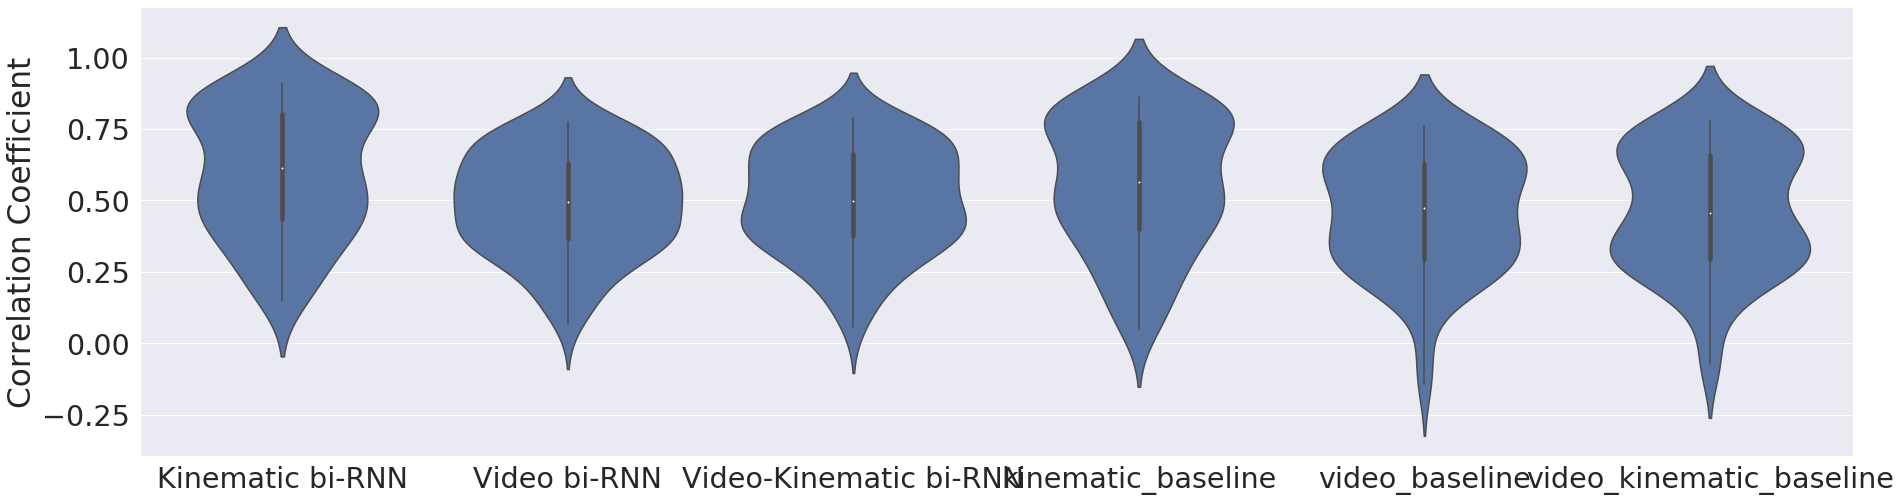

In [68]:
sns.set(rc={'figure.figsize':(30.7,8.27)})
sns.set(font_scale=2.6)
#MAKE LABELS BIGGER
# sns.pointplot(data=neuron_corrs_df)
violinplot = sns.violinplot(data=neuron_corrs_df.iloc[task_dependent_units], color='b')
violinplot.set(ylabel='Correlation Coefficient')
fig = violinplot.get_figure()
fig.savefig('../figures/cnns_summary.svg')

In [167]:
max(list(neuron_corrs_df['Kinematic bi-RNN']))

0.9109861850738525

In [ ]:
sns.set(rc={'figure.figsize':(18.7,8.27)})
sns.set(font_scale=1.5)
#MAKE LABELS BIGGER
# sns.pointplot(data=neuron_corrs_df)
barplot = sns.barplot(data=neuron_corrs_df.iloc[task_dependent_units], color='b')
barplot.set(ylabel='Correlation Coefficient (r^2)')
fig = barplot.get_figure()
fig.savefig('../figures/barplot_summary.svg')

In [106]:
list(neuron_corrs_df.columns)

['video_lr',
 'video_mlp',
 'kinematic_lr',
 'kinematic_mlp',
 'vid_kinematic_lr',
 'vid_kinematic_mlp']

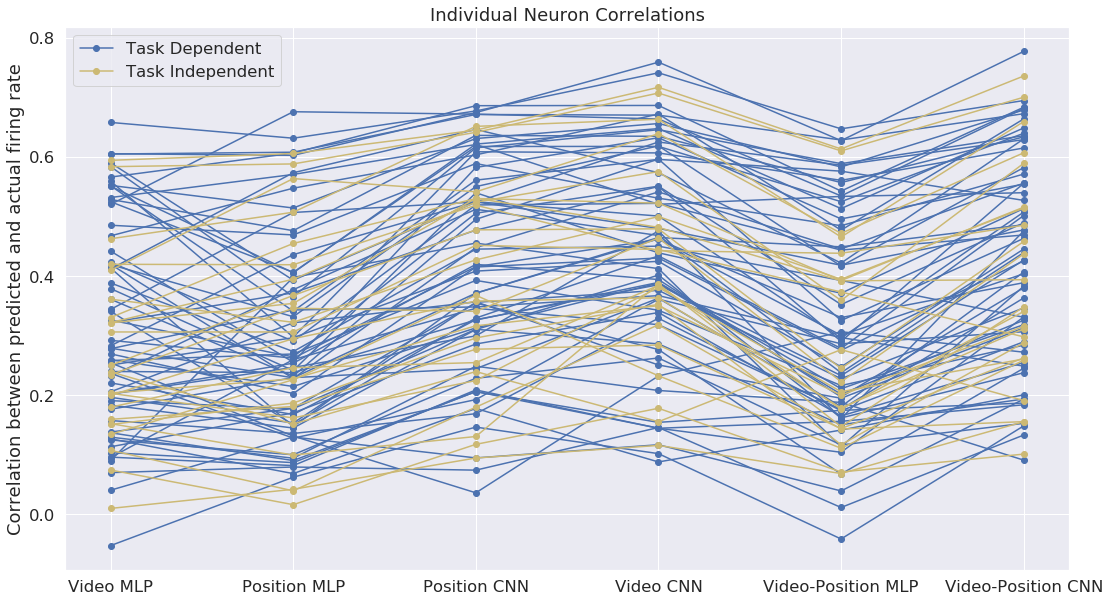

In [288]:
fig = plt.figure(figsize=(18,10))
m = np.transpose(neuron_corrs_df.to_numpy())
plt.plot(list(neuron_corrs_df.columns), m[:,task_dependent_units].reshape(6,-1), marker='o', color='b', label='Task Dependent')

mask=np.full(87,True,dtype=bool)
mask[task_dependent_units]=False
plt.plot(list(neuron_corrs_df.columns), m[:,mask], marker='o', color='y', label='Task Independent')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Individual Neuron Correlations')
plt.ylabel('Correlation between predicted and actual firing rate')
fig.savefig('../figures/neuron_correlations.svg')

In [267]:
import scipy

In [296]:
m = np.array(list(neuron_corrs.values()))
m = np.mean(m, axis=0)
m_task_dep = m[task_dependent_units]

mask = np.ones(m.size, dtype=bool)
mask[task_dependent_units] = False
m_task_ind = m[mask]
print(f'Mean correlation task dependent: {np.mean(m_task_dep)}')
print(f'Mean correlation task independent: {np.mean(m_task_ind)}')

Mean correlation task dependent: 0.37162636535333615
Mean correlation task independent: 0.34011746701366735


In [295]:
m_ind = np.array(list(neuron_corrs.values()))[:,mask].reshape(-1)
m_ind = np.concatenate((m_ind,m_ind,m_ind))
m_dep = np.array(list(neuron_corrs.values()))[:,task_dependent_units].reshape(-1)
m_dep = np.concatenate((m_dep,m_dep,m_dep))
print(f'Pvalue: {scipy.stats.ttest_ind(m_dep, m_ind)}')
print(f'STD (): {np.std(m_dep)}')

Pvalue: Ttest_indResult(statistic=3.100419062358485, pvalue=0.001966958787856948)


In [313]:
d = {}
for n,l in enumerate([video_corrs, position_corrs, video_pos_corrs]):
      d[n] = np.concatenate(np.reshape(np.vstack(l),[-1])

Text(0.5, 0, 'Video-Kinematic r^2')

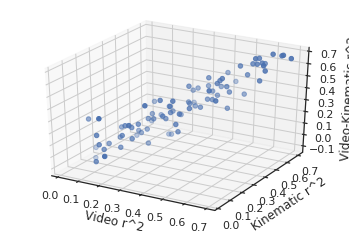

In [83]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(neuron_corrs['Video CNN'], neuron_corrs['Kinematic CNN'], neuron_corrs['Video-Kinematic CNN'])
ax.set_xlabel('Video r^2')
ax.set_ylabel('Kinematic r^2')
ax.set_zlabel('Video-Kinematic r^2')

In [130]:
X =[[neuron_corrs['Video CNN'][i], neuron_corrs['Kinematic CNN'][i], neuron_corrs['Video-Kinematic CNN'][i]] for i in range(len(neuron_corrs['Video-Kinematic CNN']))]

For n_clusters = 2 The average silhouette_score is : 0.5243419
For n_clusters = 3 The average silhouette_score is : 0.43089175
For n_clusters = 4 The average silhouette_score is : 0.43578872
For n_clusters = 5 The average silhouette_score is : 0.3796467
For n_clusters = 6 The average silhouette_score is : 0.37301025


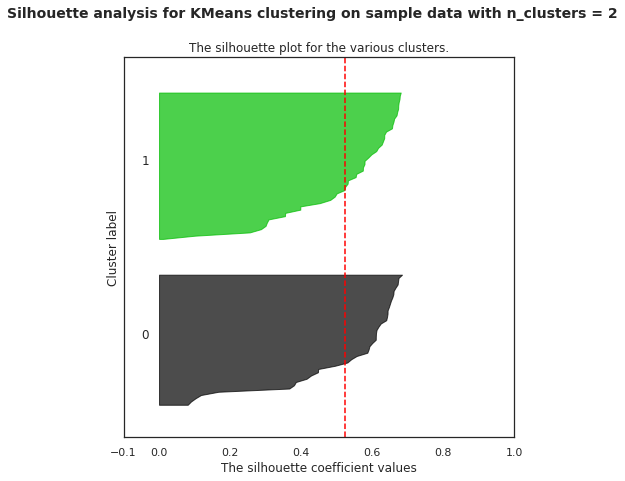

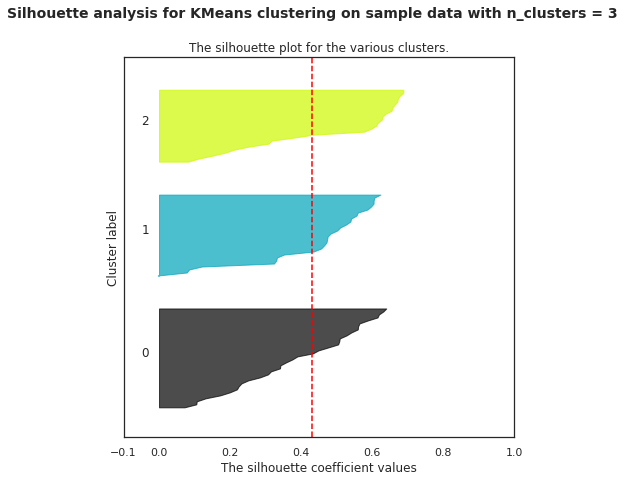

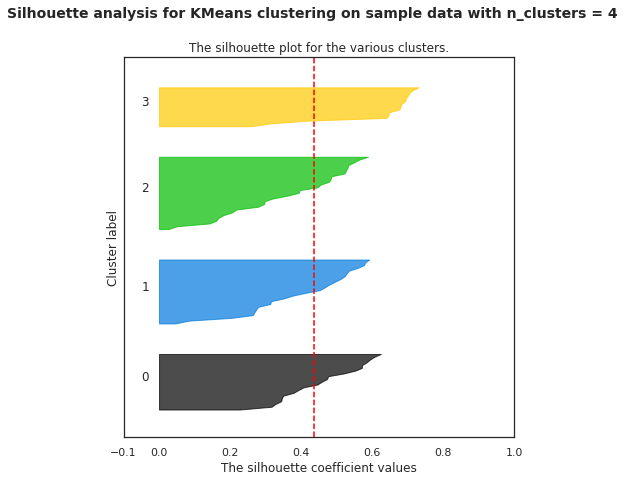

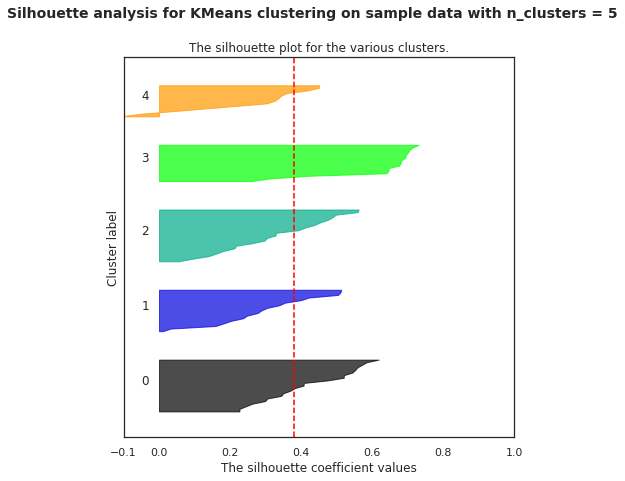

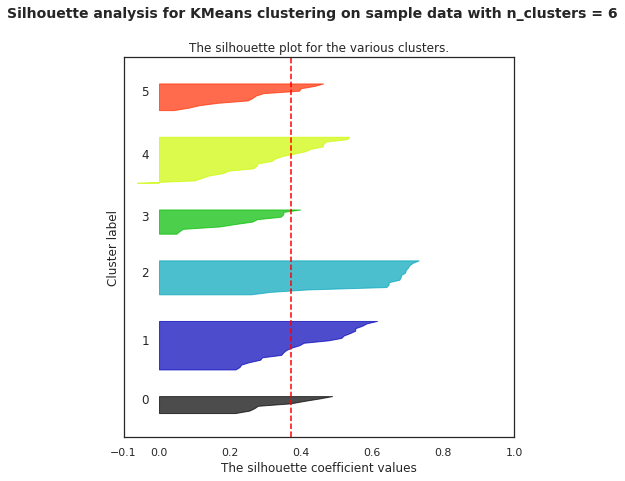

In [104]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X =[[neuron_corrs['Video CNN'][i], neuron_corrs['Kinematic CNN'][i], neuron_corrs['Video-Kinematic CNN'][i]] for i in range(len(neuron_corrs['Video-Kinematic CNN']))]

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(7, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(
#         X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
#     ax2.scatter(
#         centers[:, 0],
#         centers[:, 1],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

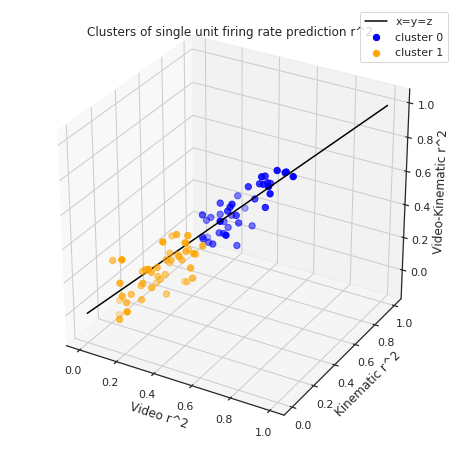

In [128]:
clusterer = KMeans(n_clusters=2, random_state=10)
y_clusters = clusterer.fit_predict(X)
X = np.array(X)
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[y_clusters == 0,0],X[y_clusters == 0,1],X[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X[y_clusters == 1,0],X[y_clusters == 1,1],X[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.plot([0,1],[0,1],[0,1], color='black', label='x=y=z')

ax.set_xlabel('Video r^2')
ax.set_ylabel('Kinematic r^2')
ax.set_zlabel('Video-Kinematic r^2')
ax.set_title('Clusters of single unit firing rate prediction r^2')
ax.legend()
plt.show()

In [5]:
with open("neuron_corrs_delay.pkl", "rb") as infile: 
    neuron_corrs_delay = pickle.load(infile)
    
neuron_corrs_delay

{'Video-Kinematic bi-RNN': array([0.5982634 , 0.6003902 , 0.5675735 , 0.7149853 , 0.7518406 ,
        0.21282814, 0.6886239 , 0.6605051 , 0.18392348, 0.46540442,
        0.22658317, 0.7128426 , 0.2959176 , 0.31288174, 0.28089723,
        0.70193815, 0.6112379 , 0.4701088 , 0.3701426 , 0.7391181 ,
        0.51212007, 0.3757101 , 0.05557247, 0.5558236 , 0.625503  ,
        0.7706695 , 0.6564528 , 0.17106359, 0.38999045, 0.5056459 ,
        0.73194236, 0.42428315, 0.46458822, 0.41852483, 0.57096386,
        0.6159479 , 0.71524   , 0.13900428, 0.37789476, 0.5952826 ,
        0.7870866 , 0.7229118 , 0.36134383, 0.44318599, 0.676826  ,
        0.4347207 , 0.60212356, 0.7794179 , 0.56211734, 0.2682426 ,
        0.42051378, 0.4148672 , 0.5488143 , 0.4154057 , 0.5892187 ,
        0.26214814, 0.14165965, 0.7103898 , 0.2622803 , 0.57523715,
        0.29012576, 0.62745595, 0.25141314, 0.53956723, 0.61087567,
        0.14348796, 0.67191243, 0.09577172, 0.6084214 , 0.34517512,
        0.49860007, 0.

In [6]:
keys = ['Video-Kinematic CNN', 'kinematic']
for key in keys:
    neuron_corrs_delay.pop(key)


In [8]:
neuron_corrs_delay_df = pd.DataFrame.from_dict(neuron_corrs_delay)
# neuron_corrs_delay_df = swap_columns(neuron_corrs_delay_df, 'kinematic_delay','video_kinematic_delay')

sns.set(rc={'figure.figsize':(30.7,8.27)})
sns.set(font_scale=2.6)
#MAKE LABELS BIGGER
# sns.pointplot(data=neuron_corrs_df)
violinplot = sns.violinplot(data=neuron_corrs_delay_df.iloc[task_dependent_units], color='b')
violinplot.set(ylabel='Correlation Coefficient')
fig = violinplot.get_figure()
fig.savefig('../figures/birnn_summary.svg')

NameError: name 'task_dependent_units' is not defined

In [61]:
from scipy.stats import ttest_ind

In [103]:
column_list= list(neuron_corrs_delay_df)
for i in range(3):
    task_data = neuron_corrs_delay_df[column_list[i]]
    delay_data = neuron_corrs_delay_df[column_list[i+3]]
    
    print(f'Mean difference {column_list[i]}, {column_list[i+3]}: {np.mean(task_data) - np.mean(delay_data)}')
    print(f'p-value {column_list[i]}, {column_list[i+3]}: {ttest_ind(task_data, delay_data)}')

Mean difference Video-Kinematic bi-RNN, video_kinematic_delay: 0.001419752836227417
p-value Video-Kinematic bi-RNN, video_kinematic_delay: Ttest_indResult(statistic=0.048155864794171575, pvalue=0.9616478949178769)
Mean difference Video bi-RNN, video_delay: 0.001382291316986084
p-value Video bi-RNN, video_delay: Ttest_indResult(statistic=0.047649655333478876, pvalue=0.962050739845917)
Mean difference Kinematic bi-RNN, kinematic_delay: 0.07555466890335083
p-value Kinematic bi-RNN, kinematic_delay: Ttest_indResult(statistic=2.3530130536281426, pvalue=0.019752366887207246)


In [47]:
with open("neuron_corrs_delay_baseline.pkl", "rb") as infile: 
    neuron_corrs_delay_baseline = pickle.load(infile)

neuron_corrs_delay_baseline_df = pd.DataFrame.from_dict(neuron_corrs_delay_baseline)
mapper = dict(zip(list(neuron_corrs_delay_baseline_df), [title + "_baseline" for title in  list(neuron_corrs_delay_baseline_df)]))
neuron_corrs_delay_baseline_df = neuron_corrs_delay_baseline_df.rename(columns = mapper)
neuron_corrs_delay_baseline_df

kinematic_delay_baseline  video_delay_baseline  \
0                   0.446320              0.397279   
1                   0.260354              0.208686   
2                   0.466907              0.390818   
3                   0.630429              0.508825   
4                   0.433730              0.276204   
..                       ...                   ...   
82                  0.632783              0.556707   
83                  0.563657              0.516861   
84                  0.690502              0.624830   
85                  0.316651              0.265583   
86                  0.184242              0.202462   

    video_kinematic_delay_baseline  
0                        -0.012332  
1                        -0.163304  
2                         0.343787  
3                         0.277497  
4                        -0.008944  
..                             ...  
82                       -0.218986  
83                       -0.286336  
84                       -0.316281  
85                       -0.175505  
86                       -0.062178  

[87 rows x 3 columns]

In [50]:
neuron_corrs_delay_df[["kinematic_delay", "video_delay", "video_kinematic_delay"]]

kinematic_delay  video_delay  video_kinematic_delay
0          0.497314     0.465588               0.443895
1          0.417877     0.386065               0.427913
2          0.519453     0.405468               0.448022
3          0.681388     0.615190               0.610183
4          0.501765     0.284628               0.258377
..              ...          ...                    ...
82         0.638857     0.625604               0.649600
83         0.582846     0.571764               0.582444
84         0.709619     0.673316               0.720491
85         0.322400     0.418653               0.415783
86         0.261039     0.348579               0.368565

[87 rows x 3 columns]

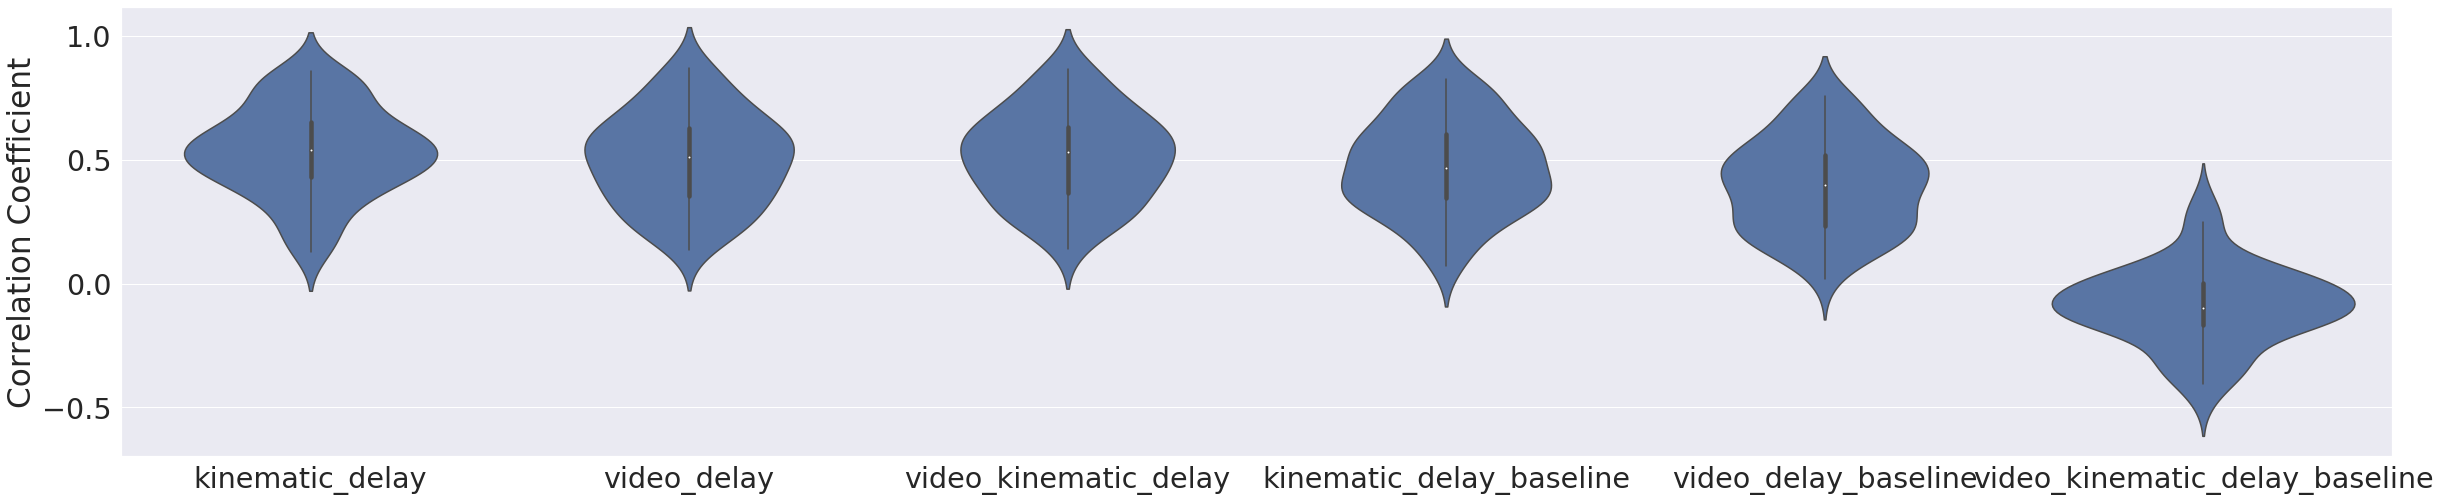

In [58]:
comparison_df = pd.concat([neuron_corrs_delay_df[["kinematic_delay", "video_delay", "video_kinematic_delay"]], neuron_corrs_delay_baseline_df], axis=1)
sns.set(rc={'figure.figsize':(40.7,8.27)})
sns.set(font_scale=2.6)
#MAKE LABELS BIGGER
# sns.pointplot(data=neuron_corrs_df)
violinplot = sns.violinplot(data=comparison_df.iloc[task_dependent_units], color='b')
violinplot.set(ylabel='Correlation Coefficient')
fig = violinplot.get_figure()
fig.savefig('../figures/delay_summary.svg')

In [59]:
comparison_df

kinematic_delay  video_delay  video_kinematic_delay  \
0          0.497314     0.465588               0.443895   
1          0.417877     0.386065               0.427913   
2          0.519453     0.405468               0.448022   
3          0.681388     0.615190               0.610183   
4          0.501765     0.284628               0.258377   
..              ...          ...                    ...   
82         0.638857     0.625604               0.649600   
83         0.582846     0.571764               0.582444   
84         0.709619     0.673316               0.720491   
85         0.322400     0.418653               0.415783   
86         0.261039     0.348579               0.368565   

    kinematic_delay_baseline  video_delay_baseline  \
0                   0.446320              0.397279   
1                   0.260354              0.208686   
2                   0.466907              0.390818   
3                   0.630429              0.508825   
4                   0.433730              0.276204   
..                       ...                   ...   
82                  0.632783              0.556707   
83                  0.563657              0.516861   
84                  0.690502              0.624830   
85                  0.316651              0.265583   
86                  0.184242              0.202462   

    video_kinematic_delay_baseline  
0                        -0.012332  
1                        -0.163304  
2                         0.343787  
3                         0.277497  
4                        -0.008944  
..                             ...  
82                       -0.218986  
83                       -0.286336  
84                       -0.316281  
85                       -0.175505  
86                       -0.062178  

[87 rows x 6 columns]

In [62]:
column_list= list(comparison_df)
for i in range(3):
    task_data = comparison_df[column_list[i]]
    delay_data = comparison_df[column_list[i+3]]
    
    print(f'Mean difference {column_list[i]}, {column_list[i+3]}: {np.mean(task_data) - np.mean(delay_data)}')
    print(f'p-value {column_list[i]}, {column_list[i+3]}: {ttest_ind(task_data, delay_data)}')

Mean difference kinematic_delay, kinematic_delay_baseline: 0.05386689305305481
p-value kinematic_delay, kinematic_delay_baseline: Ttest_indResult(statistic=1.7810694980602093, pvalue=0.07666597265484698)
Mean difference video_delay, video_delay_baseline: 0.10054624080657959
p-value video_delay, video_delay_baseline: Ttest_indResult(statistic=3.3347913929335515, pvalue=0.0010456231446216095)
Mean difference video_kinematic_delay, video_kinematic_delay_baseline: 0.5745877772569656
p-value video_kinematic_delay, video_kinematic_delay_baseline: Ttest_indResult(statistic=21.156232361648552, pvalue=9.725282221771137e-50)
